In [11]:
###Import the usual libraries
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord

#import scipy.optimize as opt
from scipy.stats import kurtosis, skew, iqr

import csv

filepath1 = '/Users/joshpovick/Desktop/Research/fits/final_dupont_oct09.fits'
filepath2 = '/Users/joshpovick/Desktop/Research/fits/dupont7.fits'
filepath3 = '/Users/joshpovick/Desktop/Research/fits/bstars.fits' #original icr stars fits
filepath4 = '/Users/joshpovick/Desktop/Research/fits/gaia6as.fits' #icr stars xmatched with bstars.fits

In [2]:
###Code to Convert to MS coordinates
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

class MagellanicStream(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the Magellanic Stream
    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    MSLongitude : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to the Magellanic Stream.
    MSLatitude : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to the Magellanic Stream.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the Stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.
    """
    default_representation = coord.SphericalRepresentation
    #default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'MSLongitude'),
            coord.RepresentationMapping('lat', 'MSLatitude'),
            coord.RepresentationMapping('distance', 'distance')]#,
        #coord.SphericalCosLatDifferential: [
        #    coord.RepresentationMapping('d_lon_coslat', 'pm_lon_coslat'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #    coord.RepresentationMapping('d_distance', 'radial_velocity')],
        #coord.SphericalDifferential: [
        #    coord.RepresentationMapping('d_lon', 'pm_lon'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #   coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    #frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
    #    frame_specific_representation_info[coord.SphericalCosLatDifferential]
    #frame_specific_representation_info[coord.UnitSphericalDifferential] = \
    #    frame_specific_representation_info[coord.SphericalDifferential]


MS_PHI = (180 + 8.5 + 90) * u.degree # Euler angles (from Nidever 2010)
MS_THETA = (90 + 7.5) * u.degree
MS_PSI = -32.724214217871349 * u.degree  # anode parameter from gal2mag.pro

D = rotation_matrix(MS_PHI, "z")
C = rotation_matrix(MS_THETA, "x")
B = rotation_matrix(MS_PSI, "z")
A = np.diag([1., 1., 1.])
MS_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, MagellanicStream)
def galactic_to_MS():
    """ Compute the transformation matrix from Galactic spherical to
        Magellanic Stream coordinates.
    """
    return MS_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, MagellanicStream, coord.Galactic)
def MS_to_galactic():
    """ Compute the transformation matrix from Magellanic Stream coordinates to
        spherical Galactic.
    """
    return matrix_transpose(MS_MATRIX)

###Actual coordinate transform from previous cell
#c_icrs = SkyCoord(ra=tmp.ra.data*u.degree, dec=tmp.dec.data*u.degree)
#c_ms = c_icrs.transform_to(MagellanicStream)
#ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [3]:
###Import Data from fits files
dupont = fits.getdata(filepath1,1)
dupont7 = fits.getdata(filepath2,1)
icr = fits.getdata(filepath3,1)
gaia6 = fits.getdata(filepath4,1)

#Create a table to xmatch with gaia
#tdupont = Table(dupont)
#astropy.io.ascii.write(tdupont,'dupont.txt')

#Create table of the xmatch data from dupont and rename columns
tdupontgaia7 = Table(dupont7)

tdupontgaia7['col1'].name = 'NAME'
tdupontgaia7['col2'].name = 'FILE'
tdupontgaia7['col3'].name = 'MEDCOUNT'
tdupontgaia7['col4'].name = 'SNR'
tdupontgaia7['col5'].name = 'RA'
tdupontgaia7['col6'].name = 'DEC'
tdupontgaia7['col7'].name = 'GLON'
tdupontgaia7['col8'].name = 'GLAT'    
tdupontgaia7['col9'].name = 'MLON'
tdupontgaia7['col10'].name = 'MLAT'
tdupontgaia7['col11'].name = 'VHELIO'
tdupontgaia7['col12'].name = 'VLSR'
tdupontgaia7['col13'].name = 'VGSR'
tdupontgaia7['col14'].name = 'STDEV'
tdupontgaia7['col15'].name = 'VERR'
tdupontgaia7['col16'].name = 'V' 
tdupontgaia7['col17'].name = 'BV'
tdupontgaia7['gaia_rad_xmatch'] = 7.0 #add in column for xmatch radius in units of as

#Create table of the xmatch data from icr and rename columns
ticrgaia6 = Table(gaia6)

ticrgaia6['col1'].name = 'NAME'
ticrgaia6['col2'].name = 'RA'
ticrgaia6['col3'].name = 'DEC'
ticrgaia6['col4'].name = 'GLON'
ticrgaia6['col5'].name = 'GLAT'
ticrgaia6['col6'].name = 'MLON'
ticrgaia6['col7'].name = 'MLAT'
ticrgaia6['col8'].name = 'V'
ticrgaia6['col9'].name = 'BV'
ticrgaia6['col10'].name = 'EBV'
ticrgaia6['col11'].name = 'VHELIO_SMARTS'
ticrgaia6['col12'].name = 'VERR_SMARTS'
ticrgaia6['col13'].name = 'VHELIO_MIKE'
ticrgaia6['col14'].name = 'VERR_MIKE'
ticrgaia6['col15'].name = 'VHELIO'
ticrgaia6['col16'].name = 'VERR'
ticrgaia6['col17'].name = 'VELTYPE'
ticrgaia6['col18'].name = 'VLSR'
ticrgaia6['col19'].name = 'VGSR'
ticrgaia6['col20'].name = 'LMCVLOS'
ticrgaia6['col21'].name = 'TEFF'
ticrgaia6['col22'].name = 'TEFFERR'
ticrgaia6['col23'].name = 'LOGG'
ticrgaia6['col24'].name = 'LOGGERR'
ticrgaia6['col25'].name = 'METAL'
ticrgaia6['col26'].name = 'METALERR'
ticrgaia6['col27'].name = 'VSINI'
ticrgaia6['col28'].name = 'VSINIERR'
ticrgaia6['gaia_rad_xmatch'] = 6.0 #add in column for xmatch radius in units of as

In [4]:
###Create a master table (includes duplicate values from Gaia)

'''Need to uncomment master.write if need to make the master fits file (if it does not already exist in the dir)'''

master=vstack([tdupontgaia7,ticrgaia6])
#master.write('master.fits',format='fits')
master.show_in_browser(jsviewer=True)
#tdupontgaia7.show_in_browser(jsviewer=True)
#ticrgaia6.show_in_browser(jsviewer=True)

In [5]:
###Find and rid the data of duplicates 

#Find duplicates in the xmatched data for dupont xmatch
nom = np.append(dupont['NAME'],icr['NAME'])
idx = []
for i in range(len(dupont['NAME'])+len(icr['NAME'])):
    a = [j for j,x in enumerate(master['NAME']) if x == nom[i]]
    idx.append(a)

b = [k for k, y in enumerate(idx) if len(idx[k])>1]

print(master['dist'][6],'1st set 6')
print(master['dist'][7],'1st set 7')
print(master['dist'][10],'2nd set 10')
print(master['dist'][11],'2nd set 11')
print(master['dist'][19],'3rd set 19')
print(master['dist'][72],'3rd set 72')
print(master['dist'][25],'4th set 25')
print(master['dist'][110],'4th set 110')
print(master['dist'][30],'5th set 30')
print(master['dist'][31],'5th set 31')
print(master['dist'][34],'6th set 34')
print(master['dist'][112],'6th set 112')
print(master['dist'][38],'7th set 38')
print(master['dist'][39],'7th set 39')
print(master['dist'][41],'8th set 41')
print(master['dist'][97],'8th set 97')
print(master['dist'][61],'9th set 61')
print(master['dist'][62],'9th set 62')
print(master['dist'][63],'9th set 63')
print(master['dist'][78],'10th set 78')
print(master['dist'][79],'10th set 79')
print(master['dist'][91],'11th set 91')
print(master['dist'][92],'11th set 92')
print(master['dist'][93],'11th set 93')
print(master['dist'][94],'11th set 94')
print(master['dist'][101],'12th set 101')
print(master['dist'][102],'12th set 102')
print(master['dist'][103],'13th set 103')
print(master['dist'][104],'13th set 104')
print(master['dist'][107],'14th set 107')
print(master['dist'][108],'14th set 108')

keepidx = np.arange(0,113,1)
keepidx = np.delete(keepidx,[6,11,19,25,30,39,41,61,62,79,91,93,94,102,103,107,112])

0.0013329404313994523 1st set 6
0.001069520681831953 1st set 7
0.0013427844186541524 2nd set 10
0.001876164058679628 2nd set 11
0.0016100872359973587 3rd set 19
0.0014909744298278625 3rd set 72
0.00038846111968870604 4th set 25
0.00029190641154205844 4th set 110
0.0013850130816626253 5th set 30
0.0002932646947508425 5th set 31
0.00010669952672153618 6th set 34
0.00017279495968089154 6th set 112
0.00021683046425657182 7th set 38
0.00028291425940975344 7th set 39
0.00019655193732498577 8th set 41
0.00012332004922331952 8th set 97
0.0003870779240463749 9th set 61
0.0004891856993454044 9th set 62
0.0001310590498981866 9th set 63
0.00027183359662679937 10th set 78
0.0007319319061193451 10th set 79
0.0002516200281465006 11th set 91
0.00018245222244884065 11th set 92
0.001096504914554649 11th set 93
0.0014924776521785456 11th set 94
0.00016380929610812324 12th set 101
0.0008585820121563038 12th set 102
0.0010193642031356732 13th set 103
0.0004168027392292934 13th set 104
0.0014728205016436855

In [6]:
#Pick out all relavent data from master.fits

gaiara = []
gaiadec = []
pmra = []
pmdec = []
vlsr = []
vhelio = []
BPRP = []
BPG = []
GRP = []

for i in keepidx:
    gaiara.append(master['ra'][i]) 
    gaiadec.append(master['dec'][i])
    pmra.append(master['pmra'][i])
    pmdec.append(master['pmdec'][i])
    vlsr.append(master['VLSR'][i])
    vhelio.append(master['VHELIO'][i])
    BPRP.append(master['bp_rp'][i])
    BPG.append(master['bp_g'][i])
    GRP.append(master['g_rp'][i])
    
#Transform gaia ra and dec to L and B
c_icrs = SkyCoord(ra=gaiara*u.degree, dec=gaiadec*u.degree)
c_ms = c_icrs.transform_to(MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

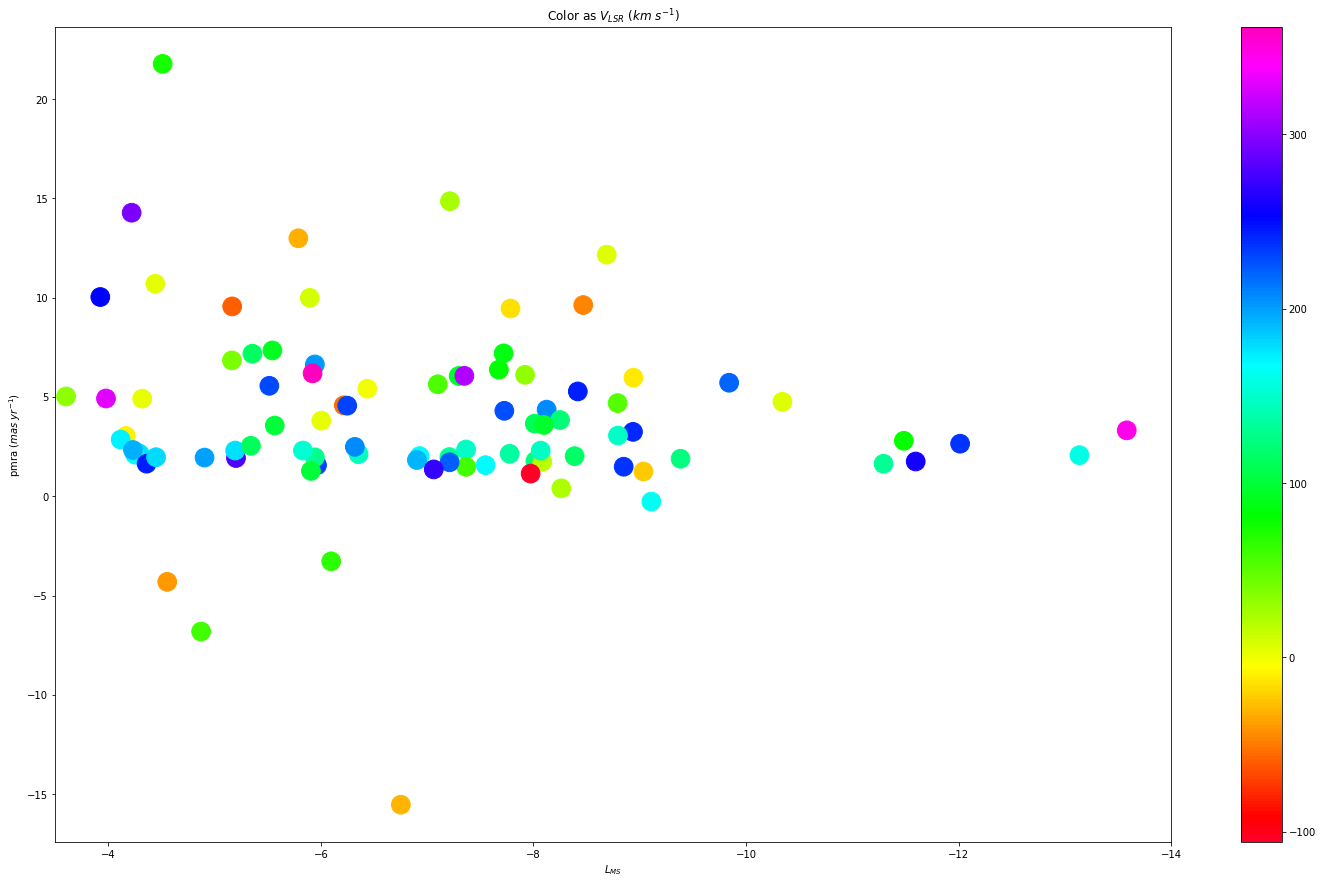

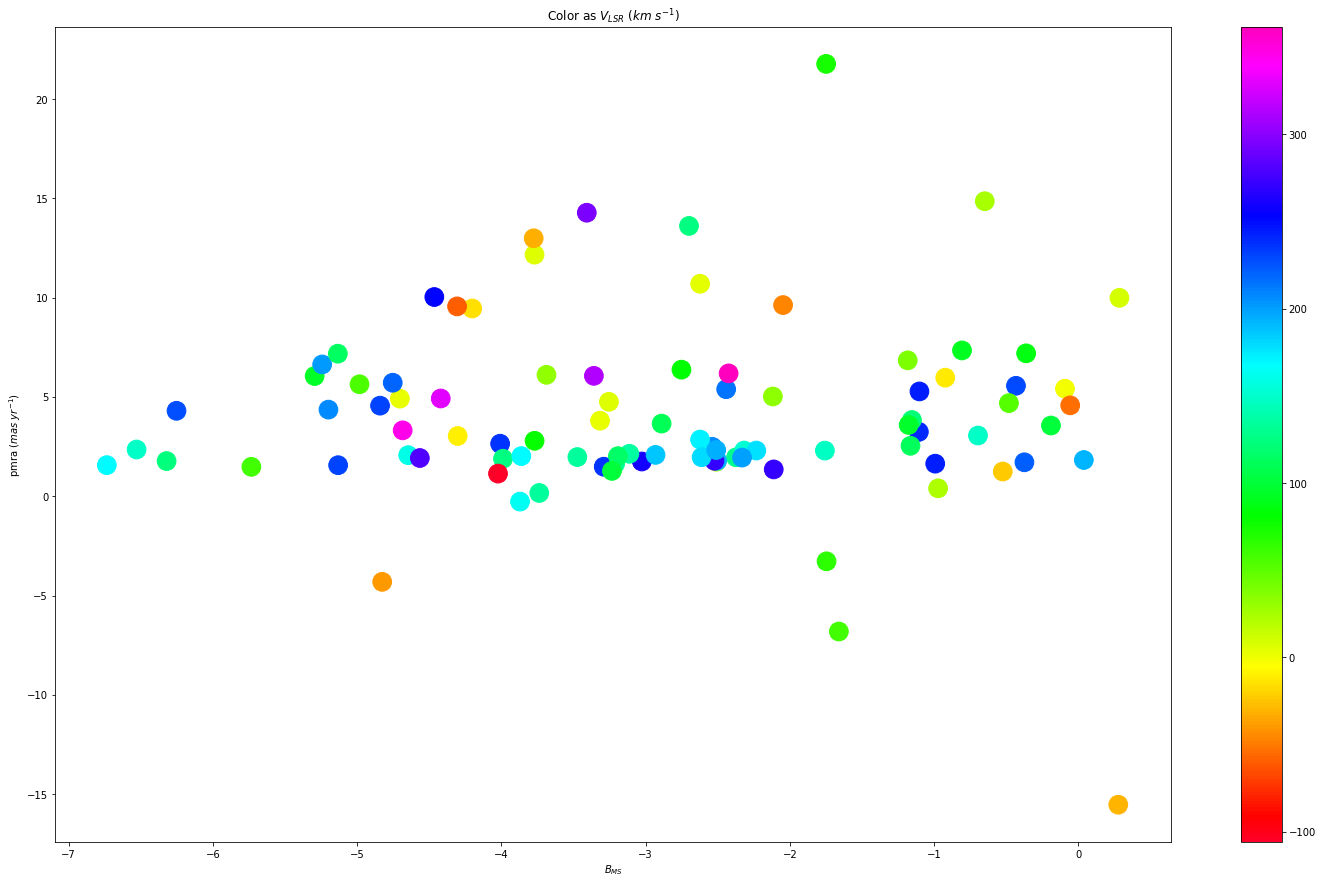

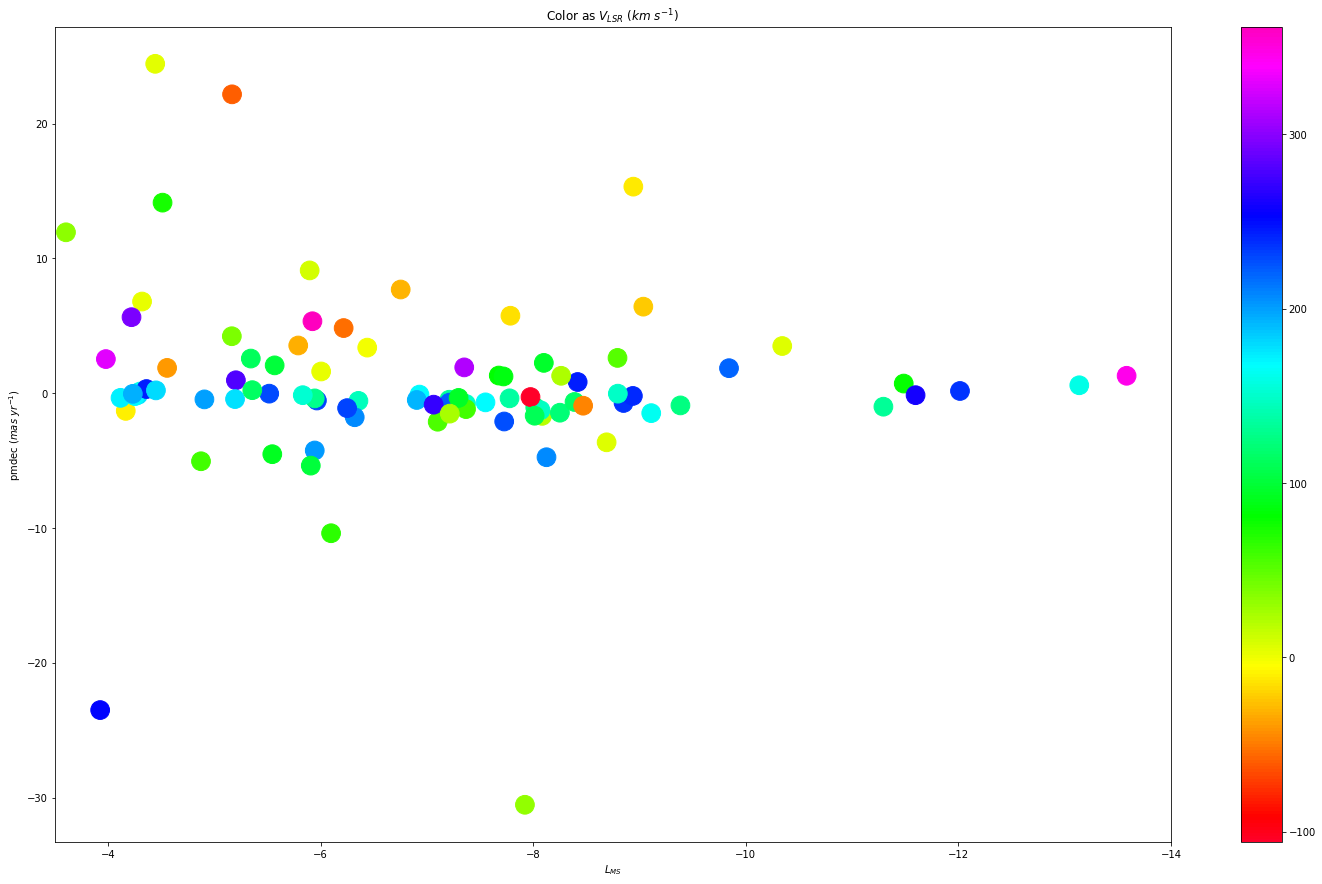

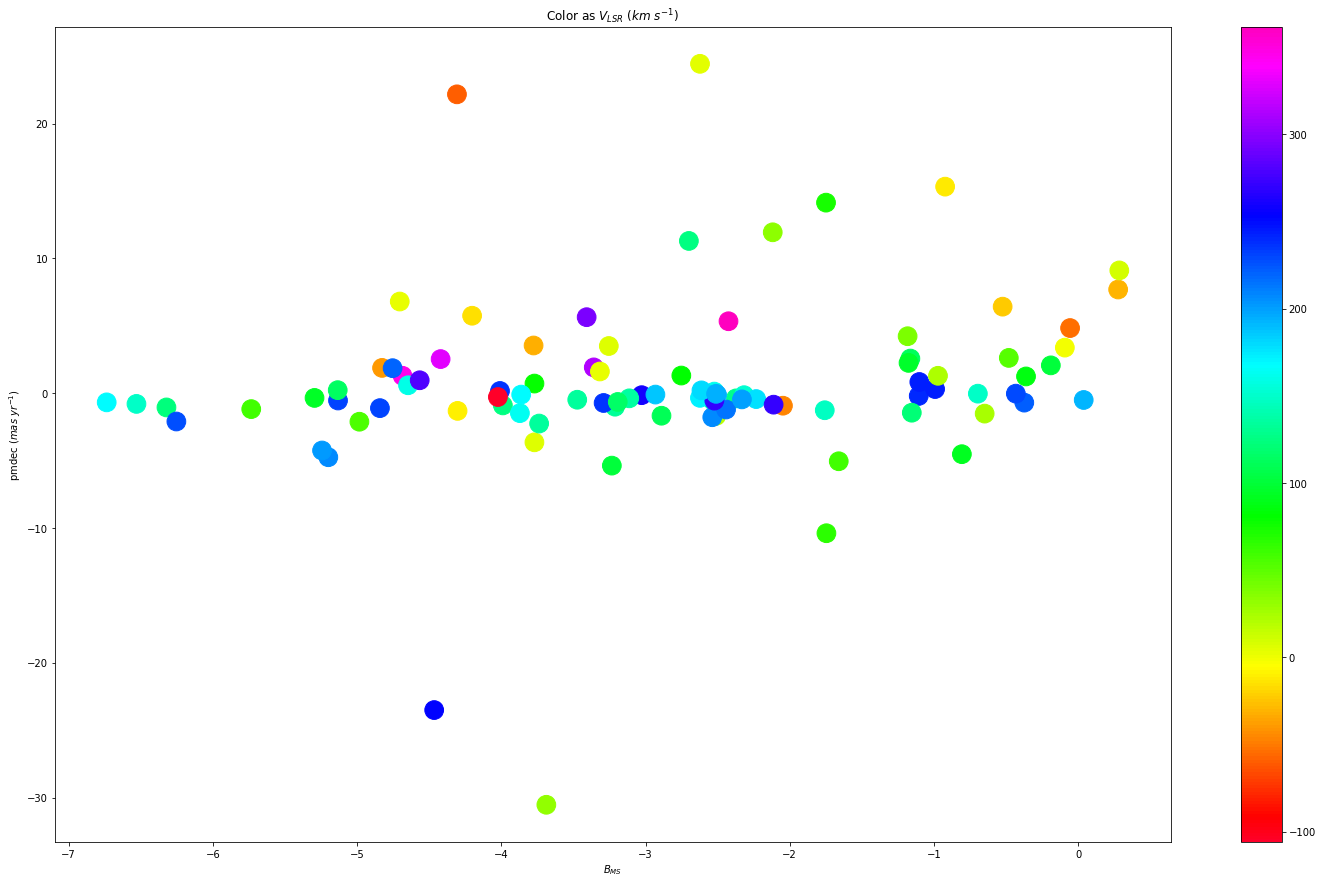

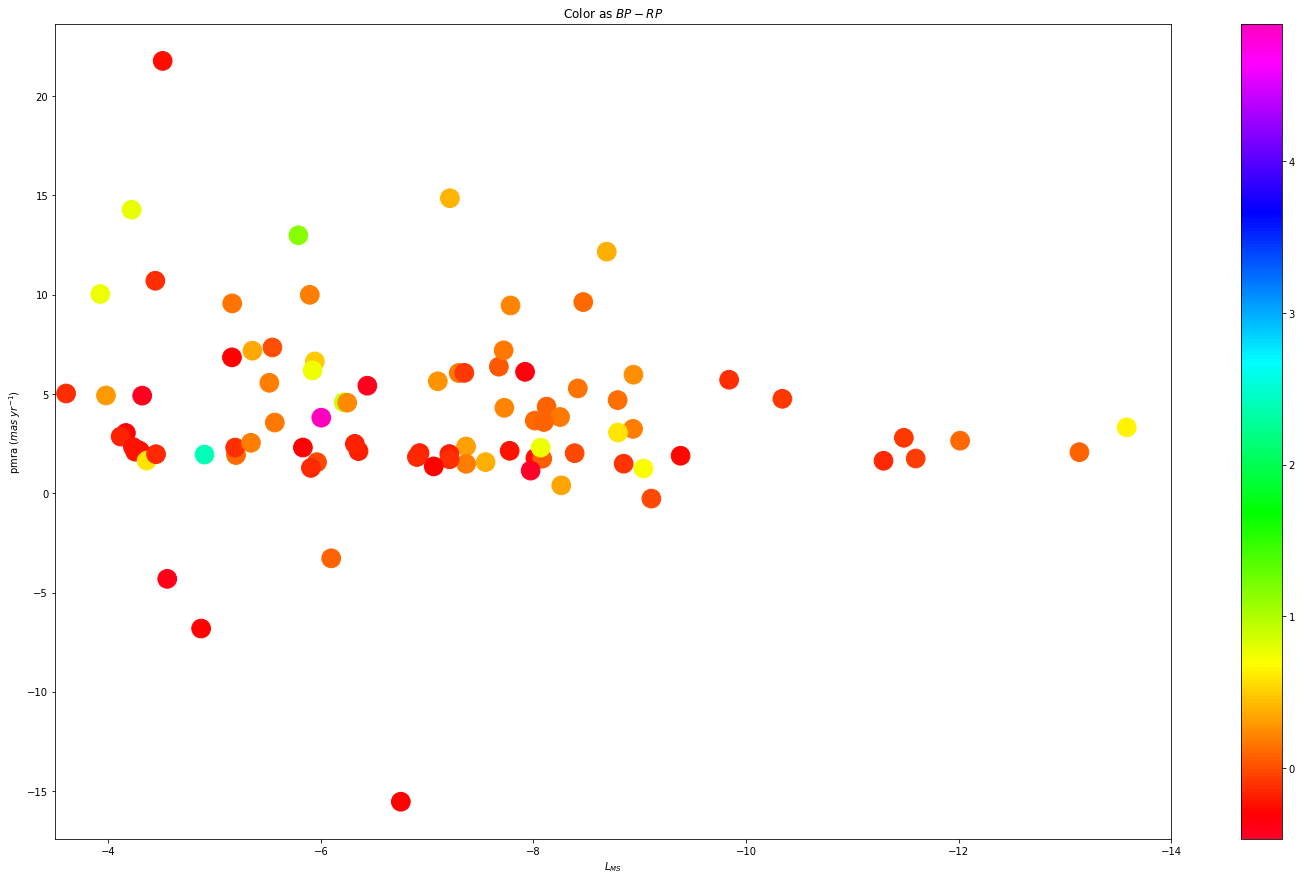

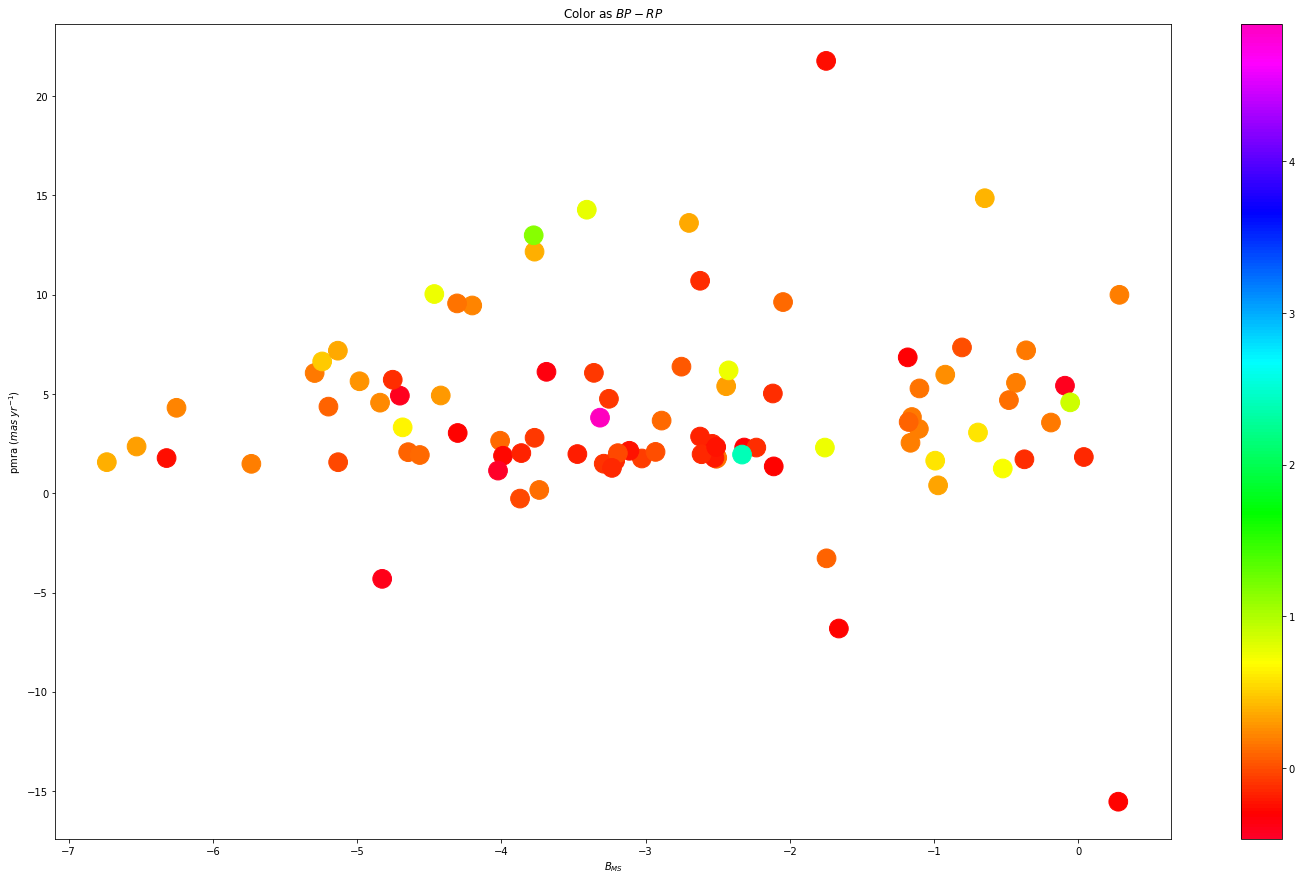

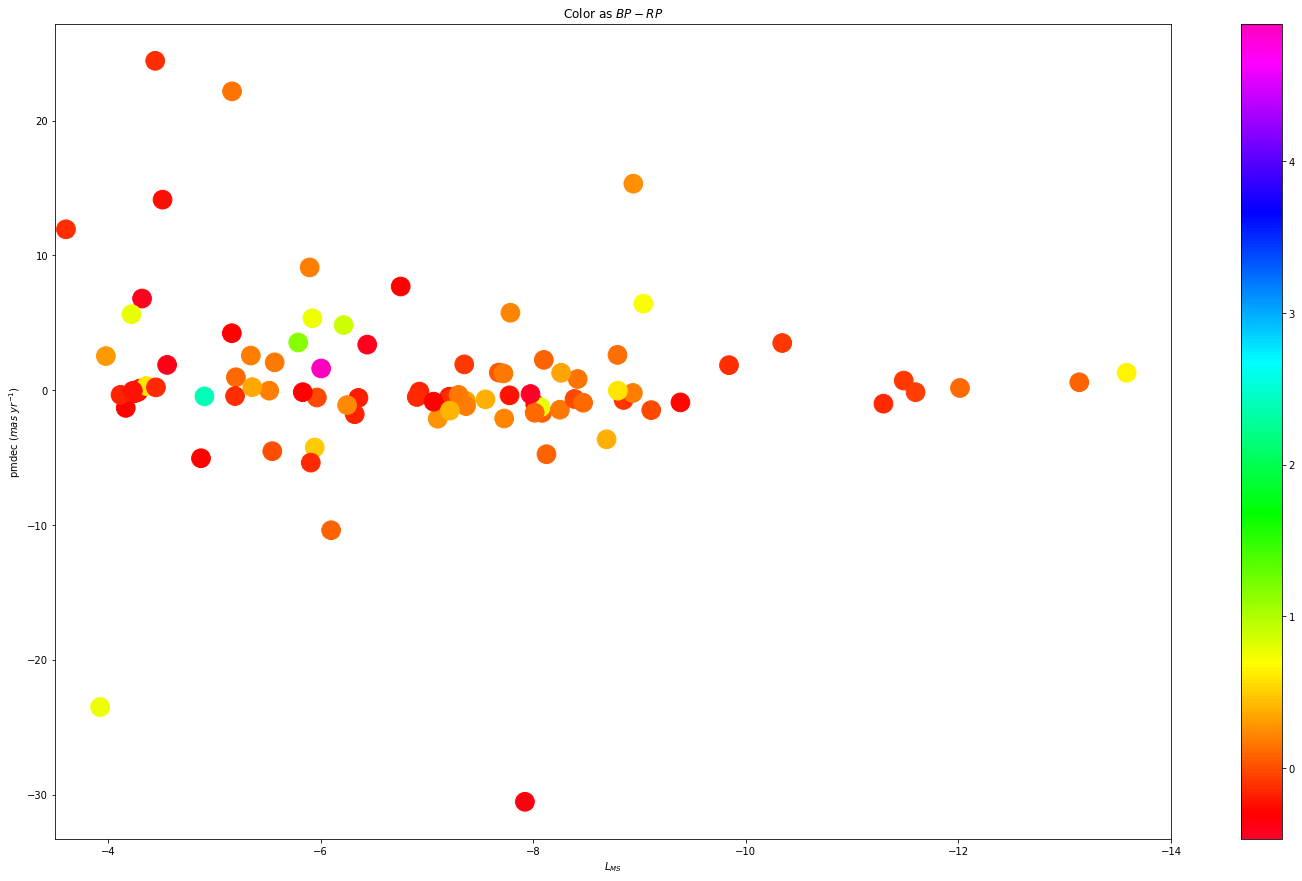

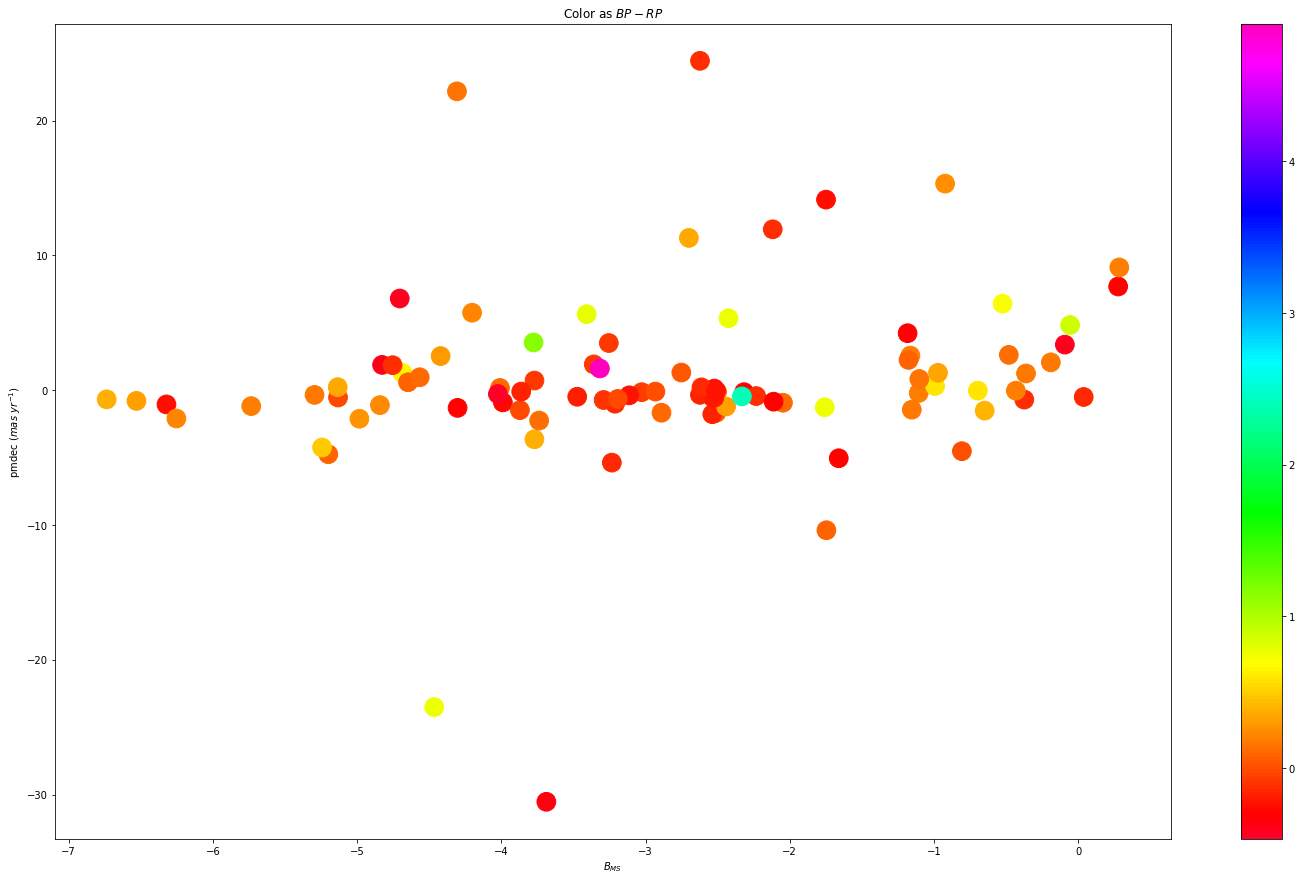

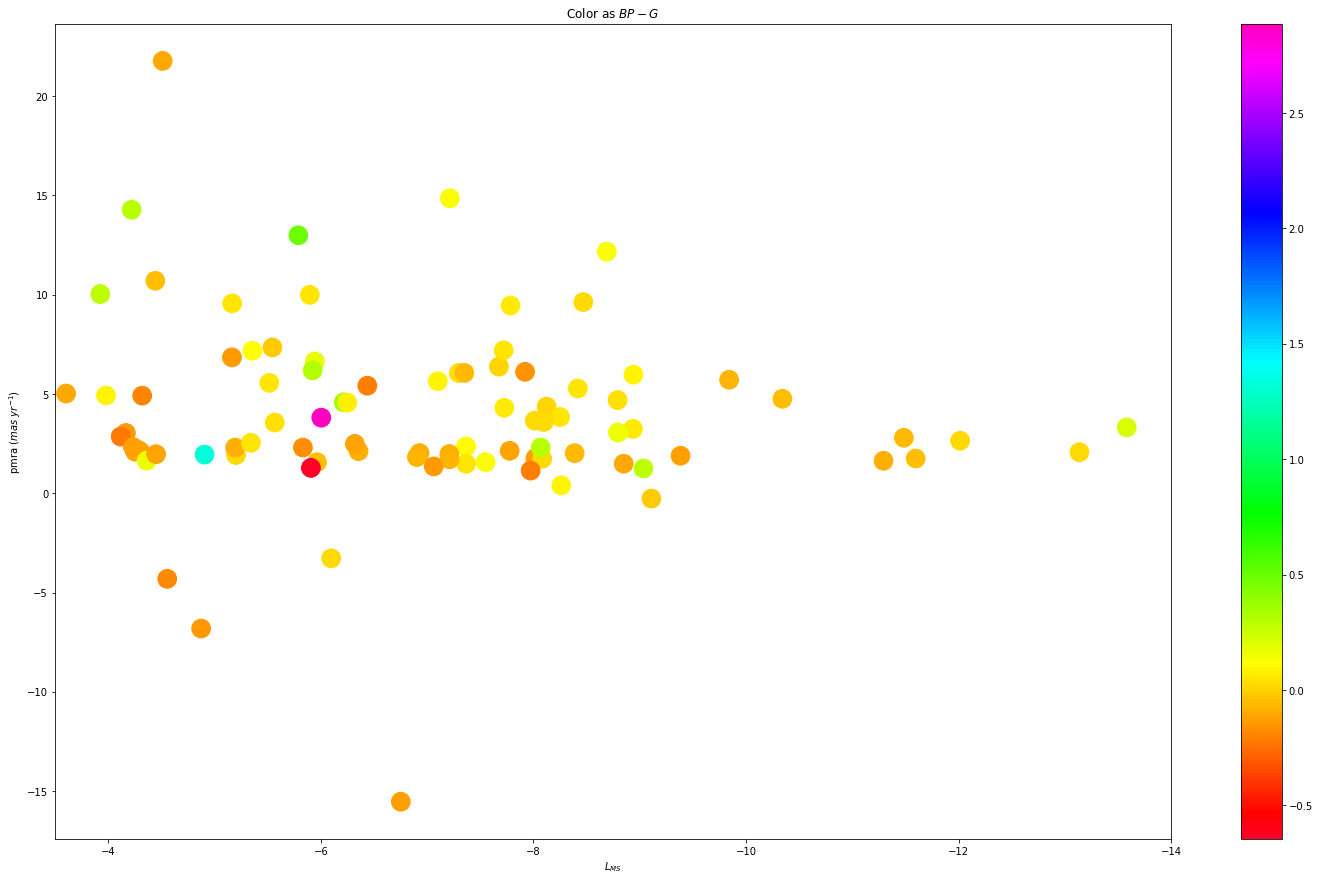

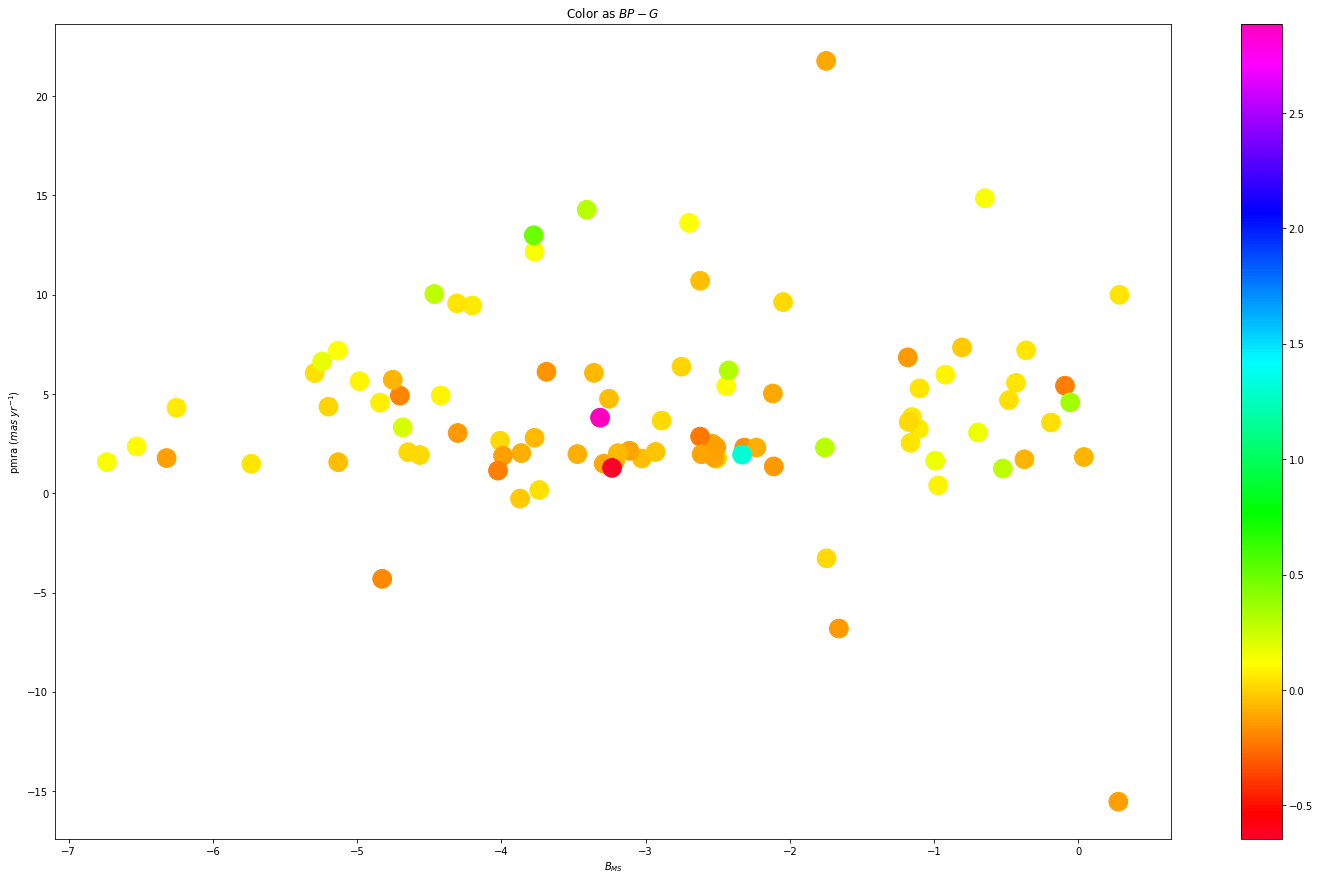

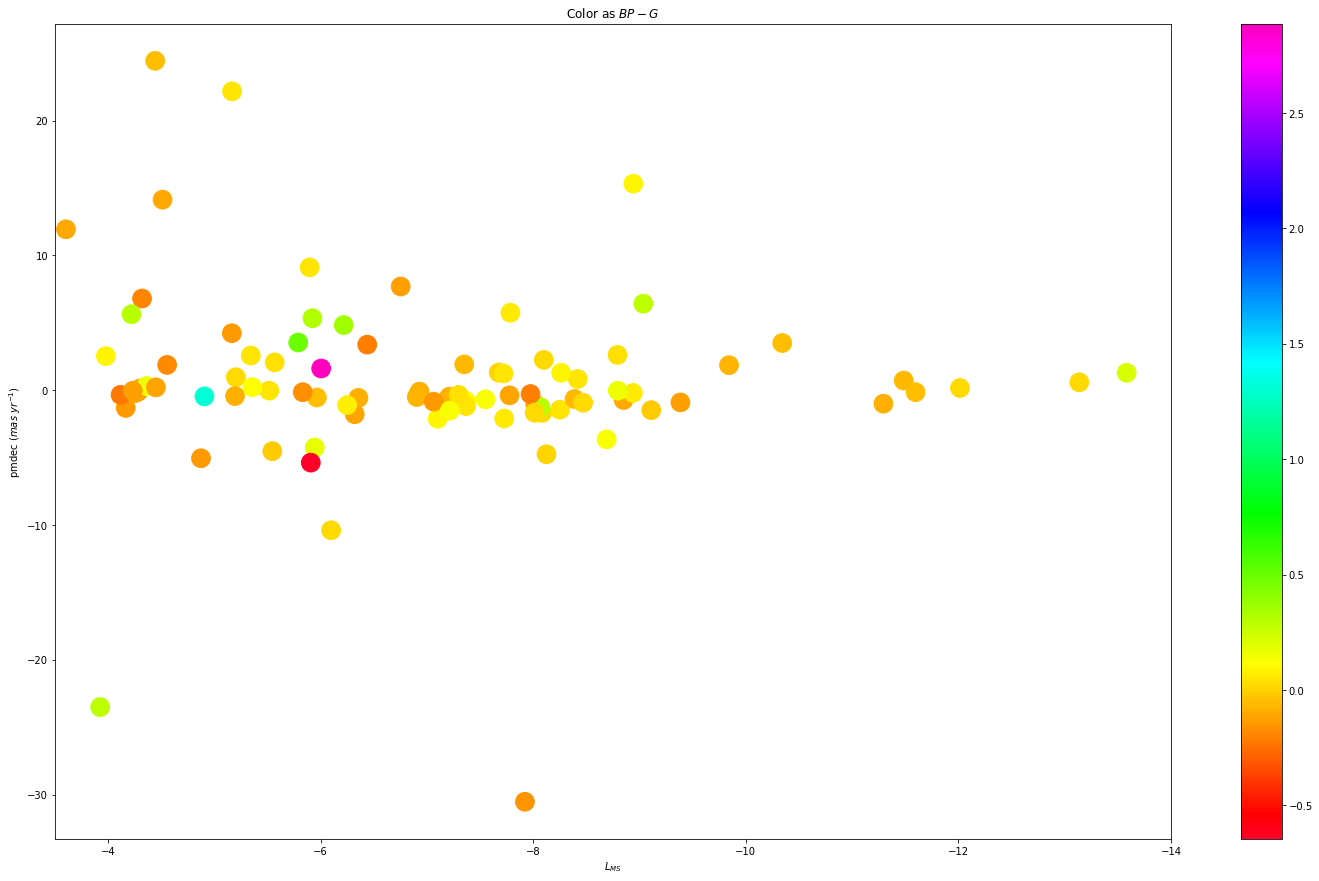

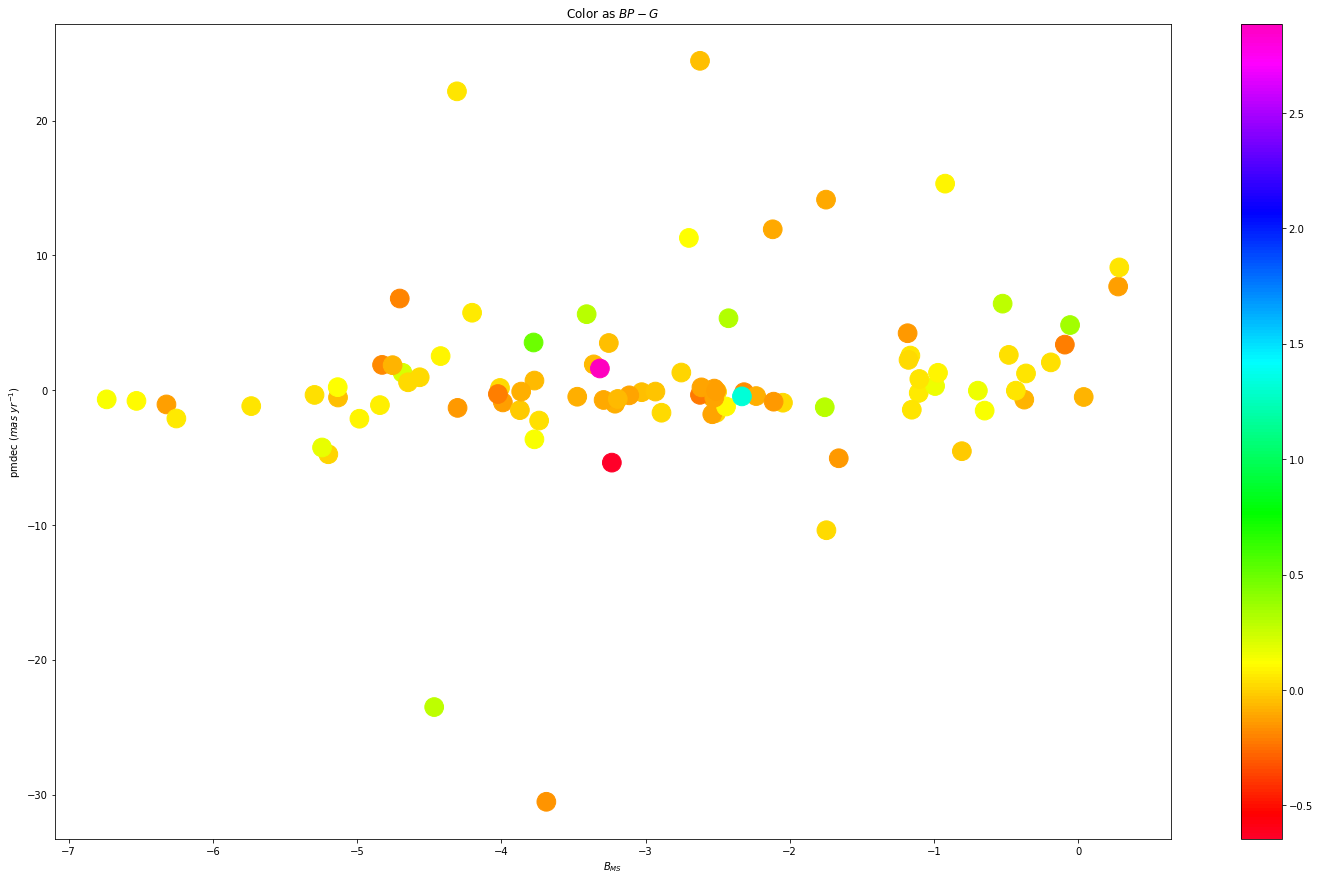

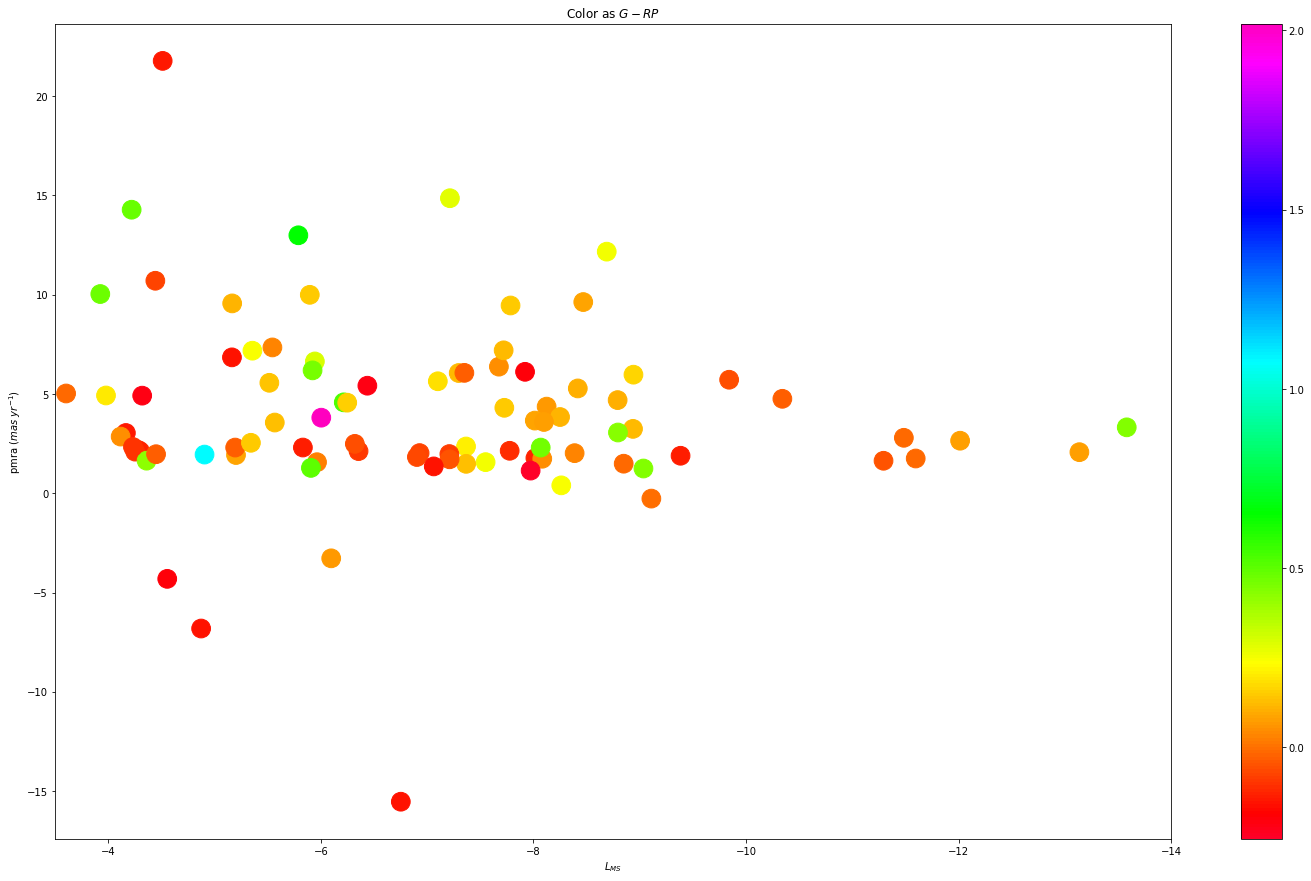

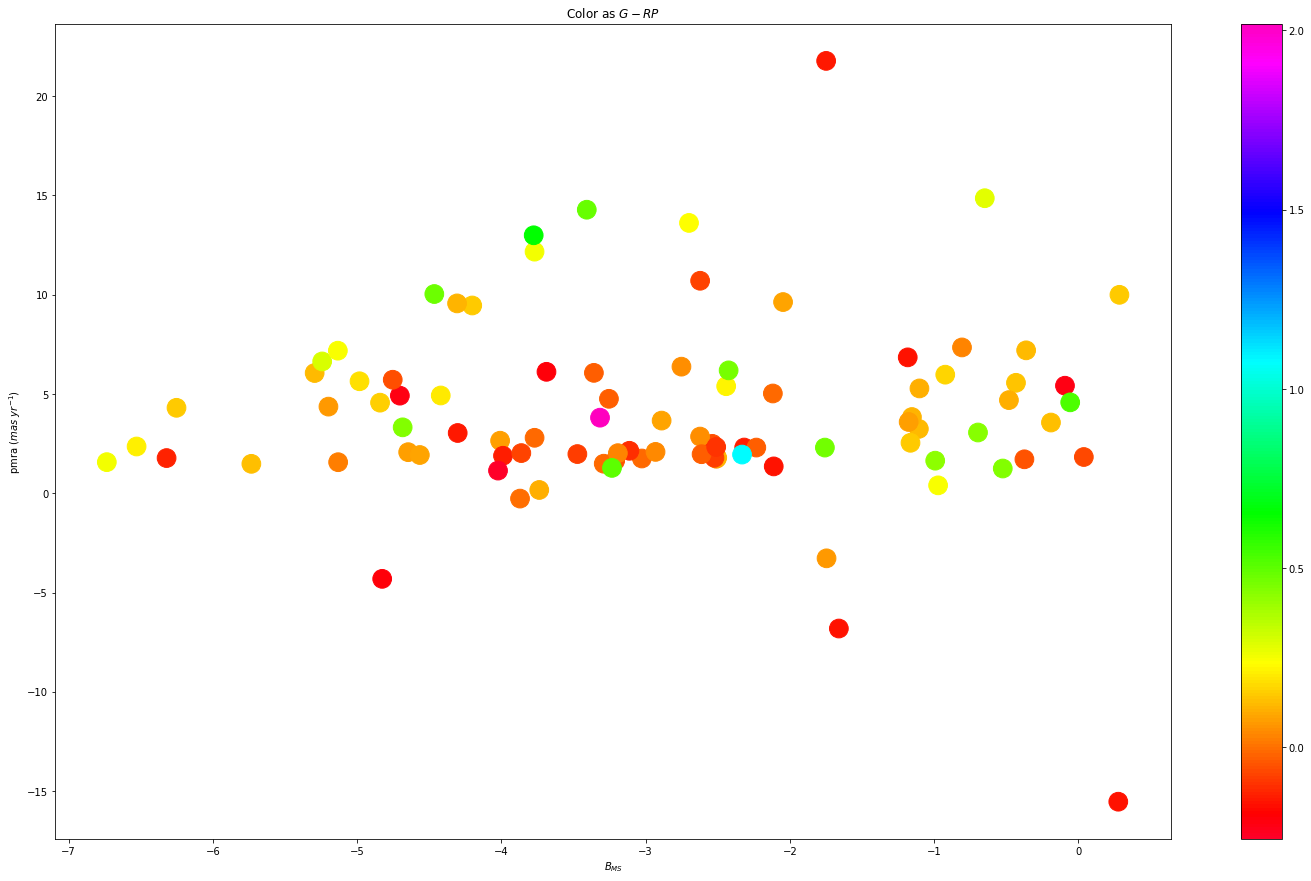

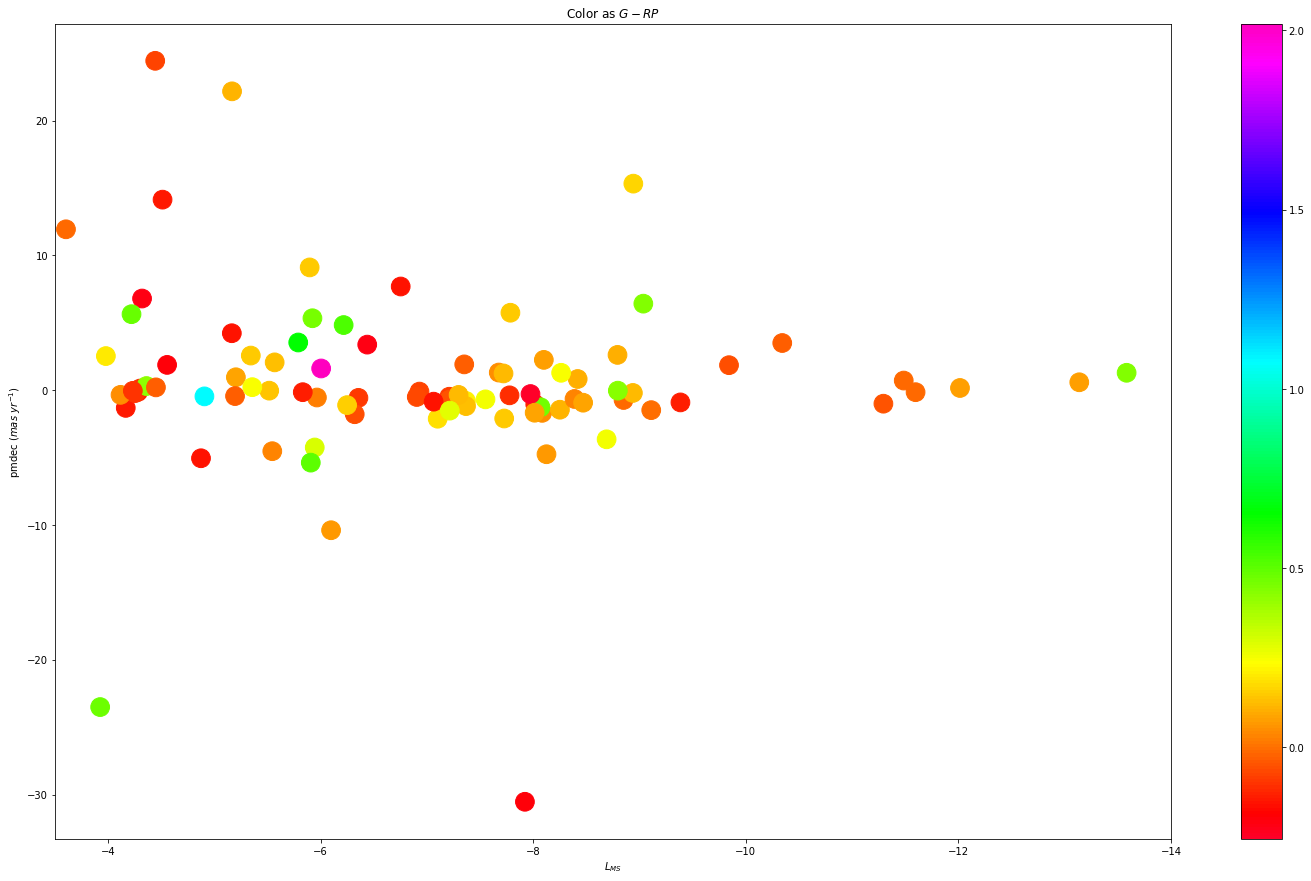

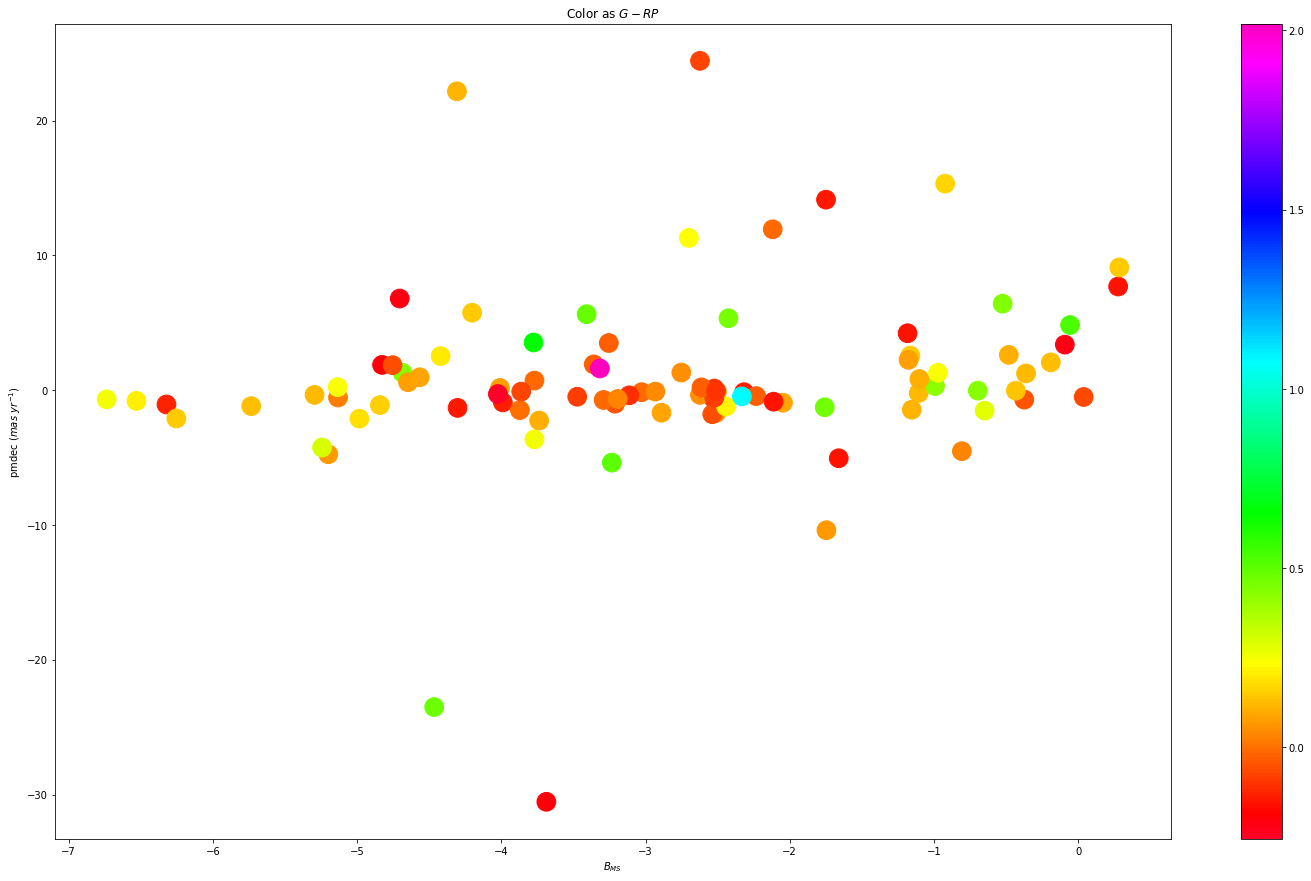

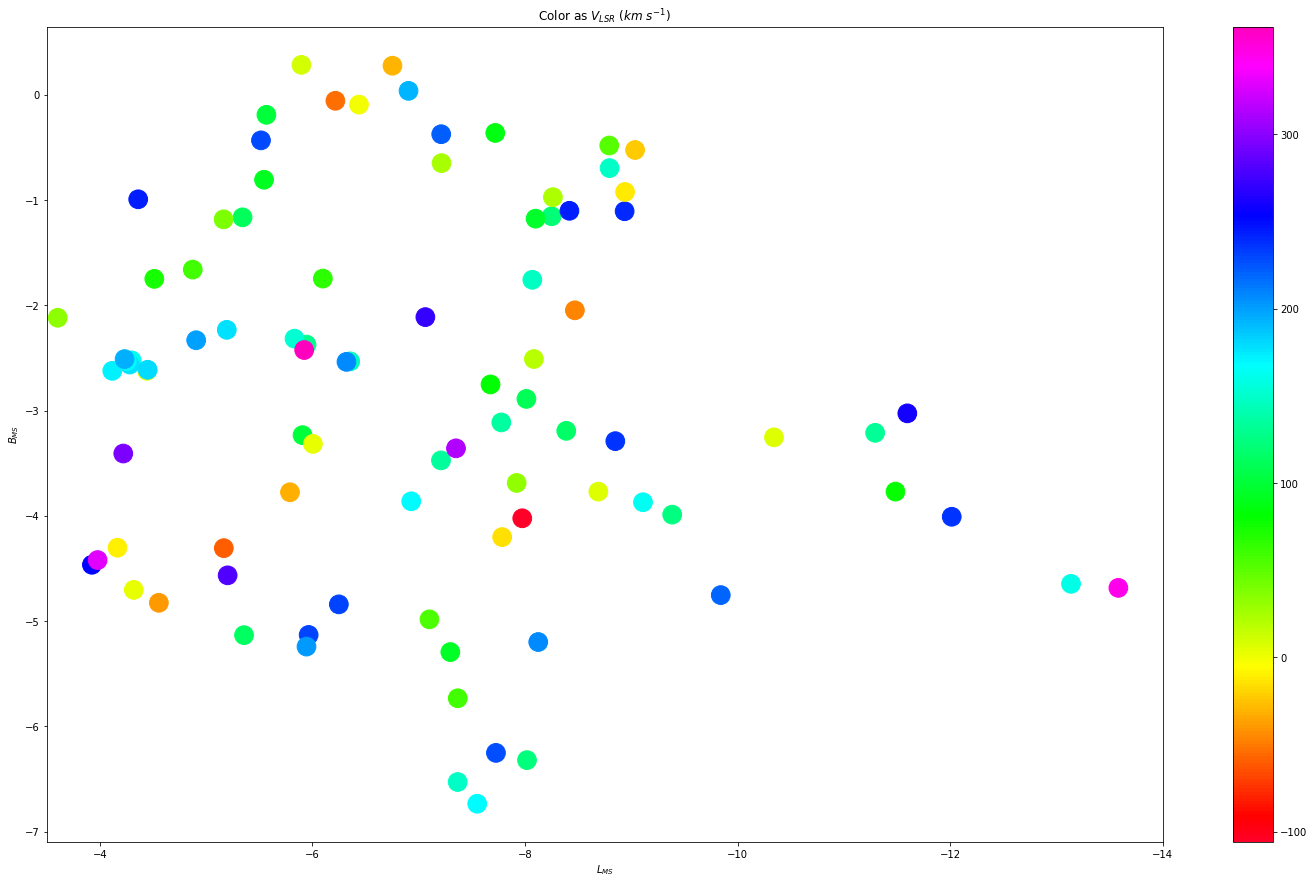

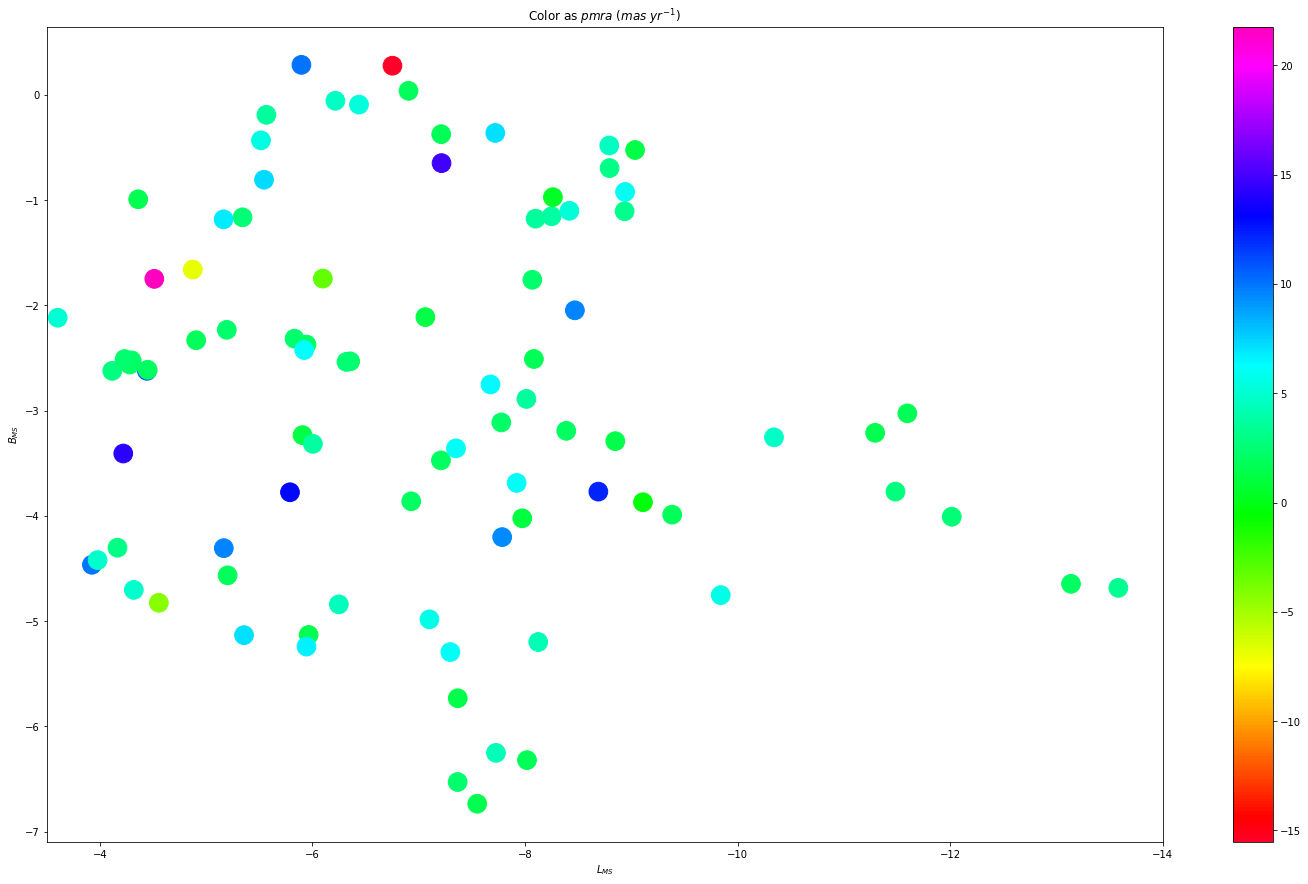

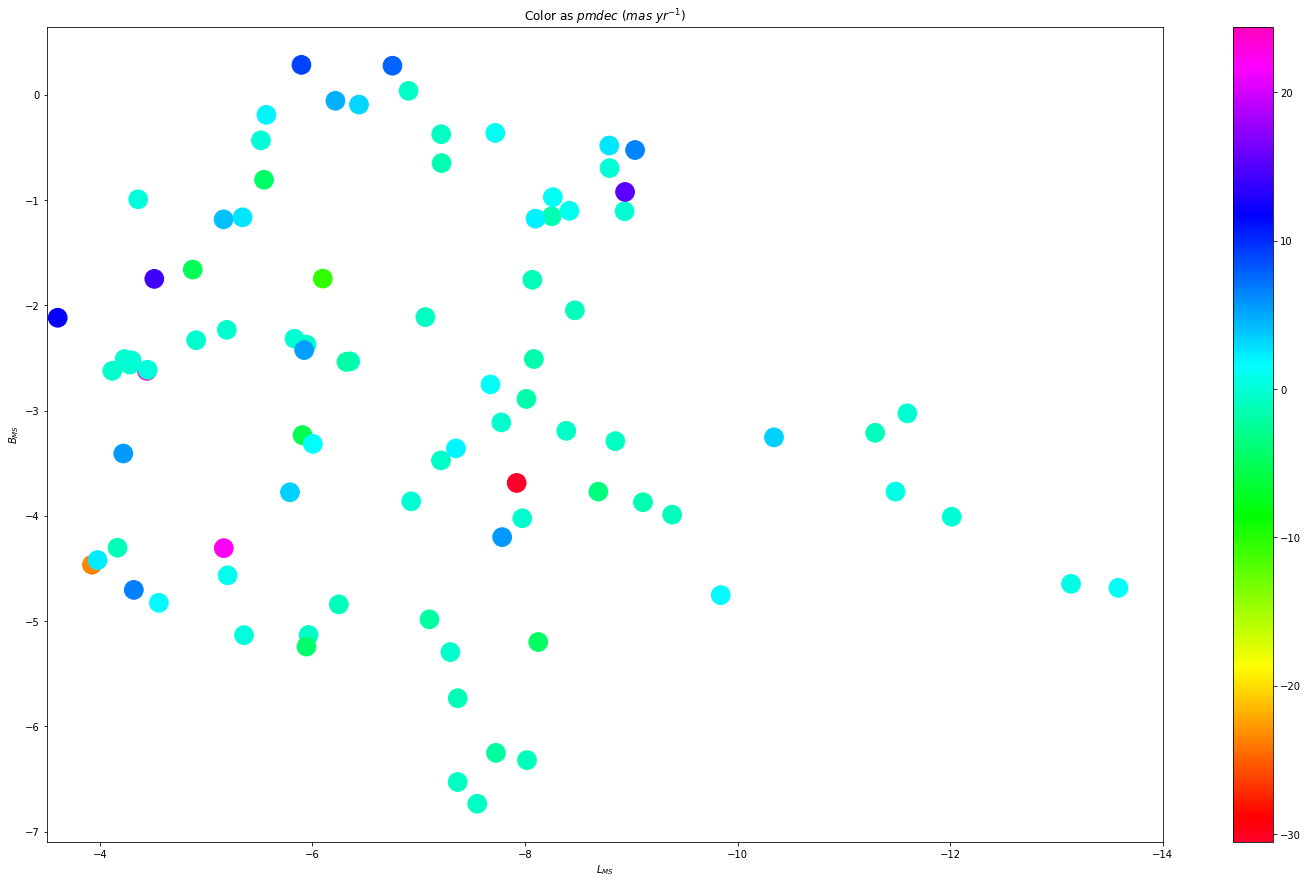

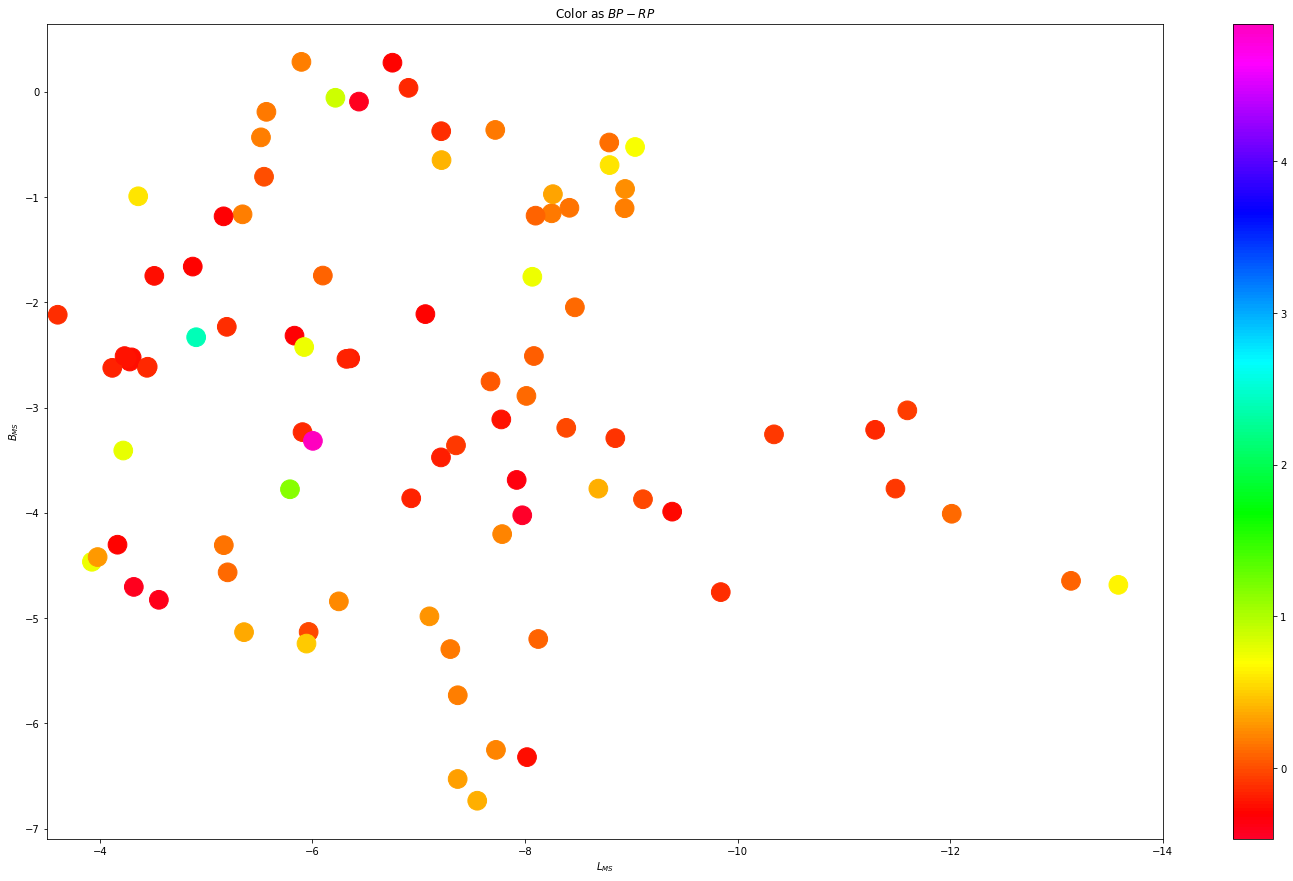

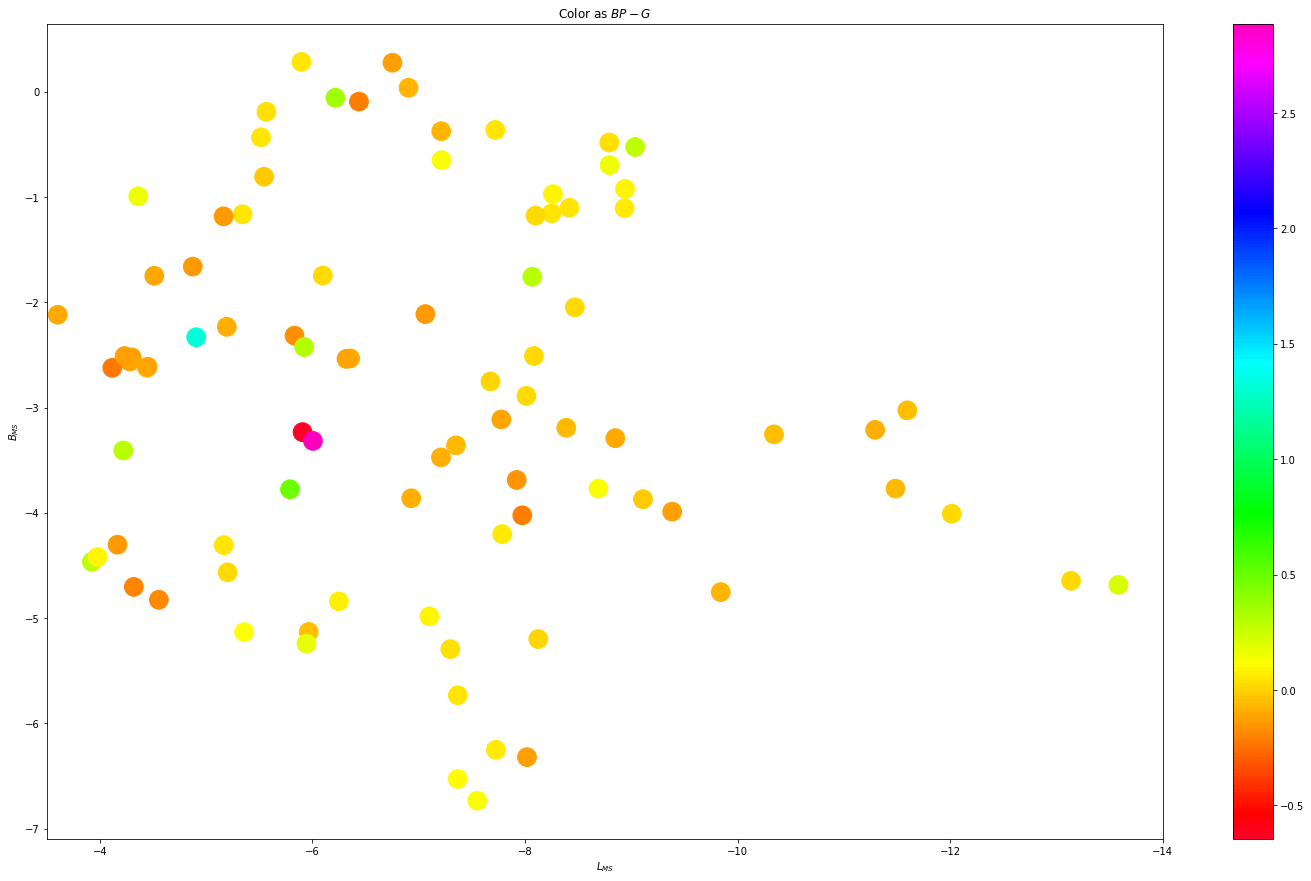

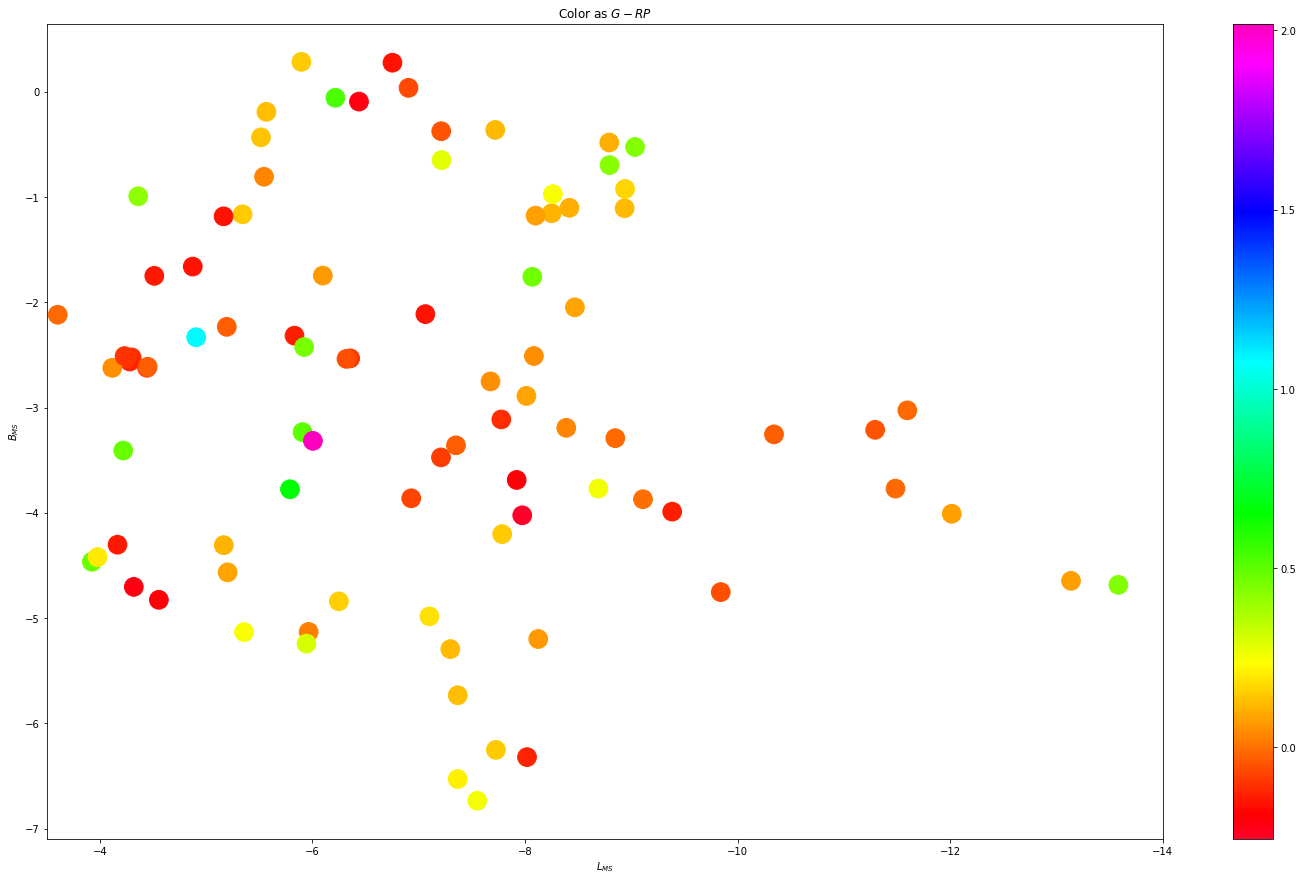

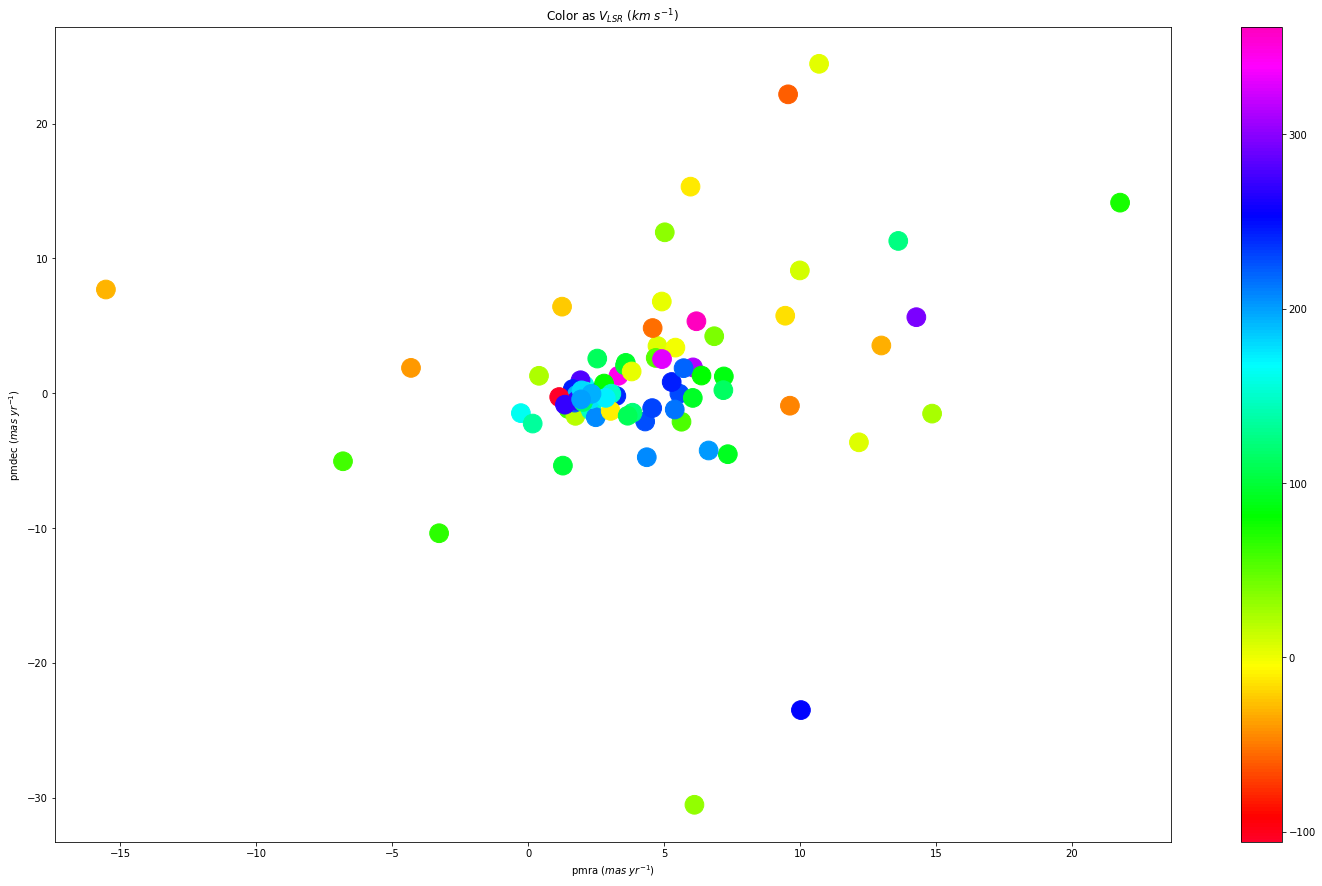

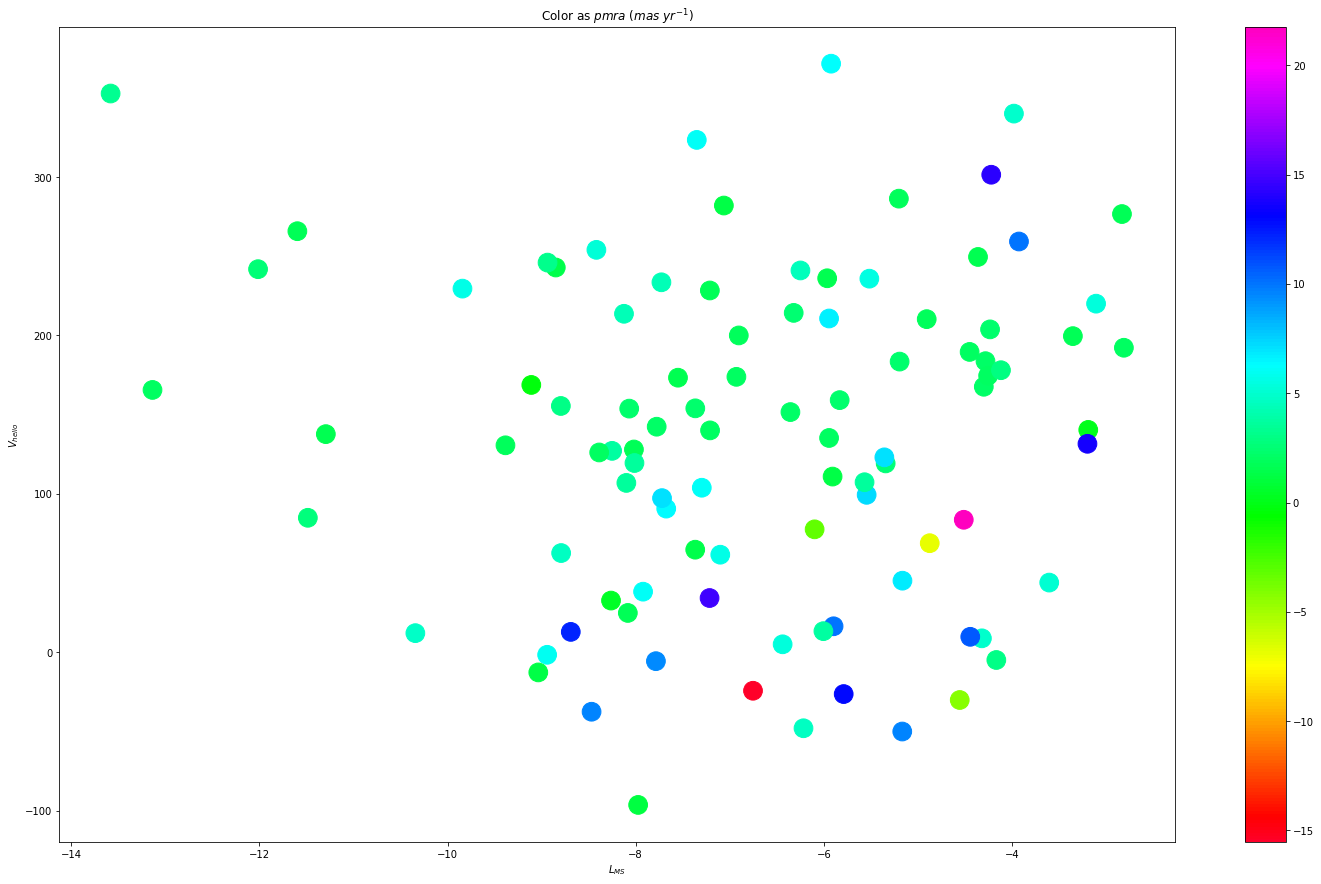

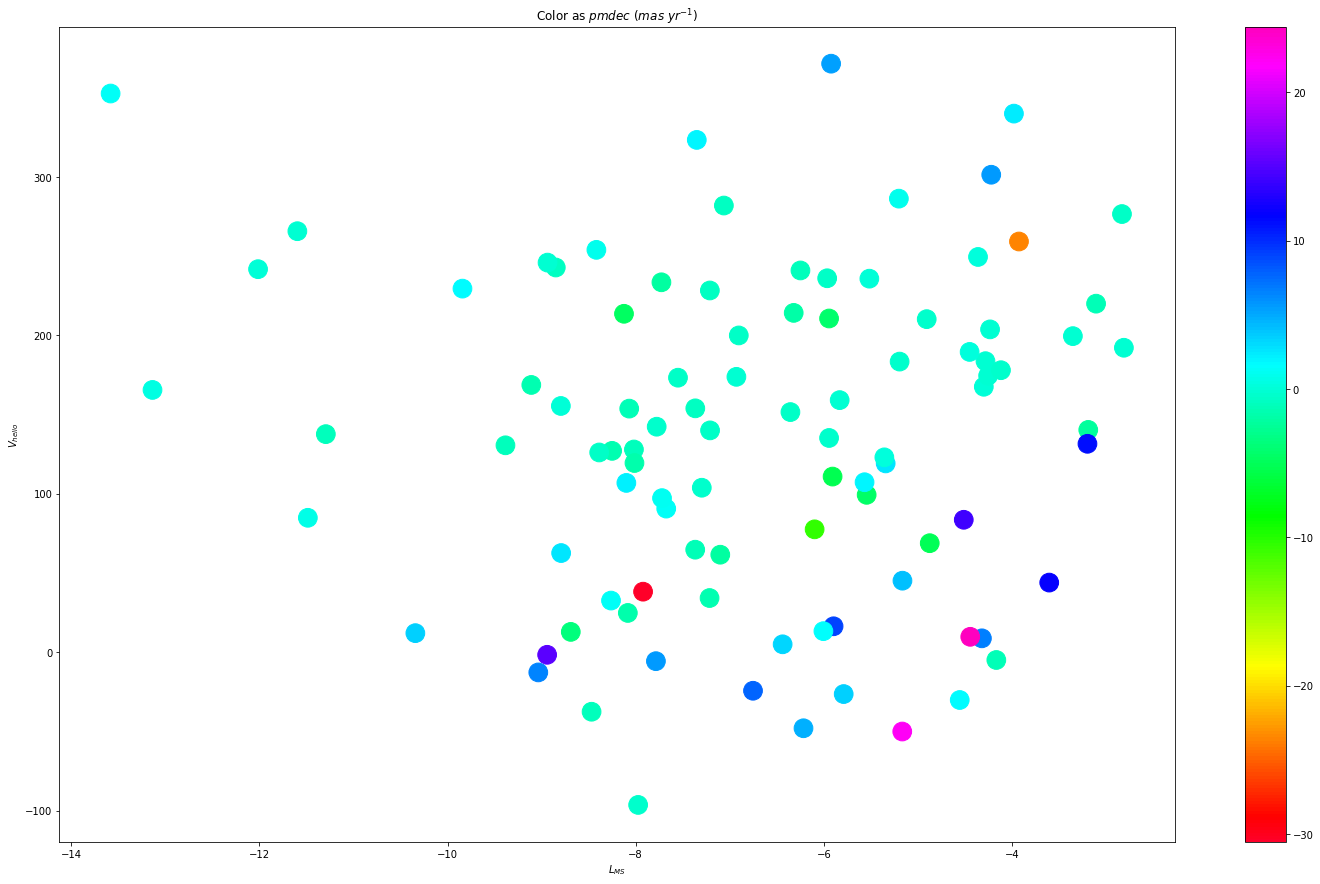

In [7]:
###Data Plots

#pmra, L, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra ($mas$ $yr^{-1}$)')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmra_L_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1}$)')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmra_B_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_L_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_B_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmra_L_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmra_B_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmdec_L_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmdec_B_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmra_L_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmra_B_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmdec_L_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmdec_B_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmra_L_grp2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmra_B_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmdec_L_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmdec_B_grp2.pdf', bbox_inches='tight')
plt.show()

#positon, vlsr
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('position_vlsr2.pdf', bbox_inches='tight')
plt.show()

#position, pmra
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=pmra,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $pmra$ $(mas$ $yr^{-1})$')
plt.savefig('positon_pmra2.pdf', bbox_inches='tight')
plt.show()

#position, pmdec
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=pmdec,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $pmdec$ $(mas$ $yr^{-1})$')
plt.savefig('position_pmdec2.pdf', bbox_inches='tight')
plt.show()

#position, BP-RP
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=BPRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('position_bprp2.pdf', bbox_inches='tight')
plt.show()

#position, BP-G
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=BPG,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('position_grp2.pdf', bbox_inches='tight')
plt.show()

#position, G-RP
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=GRP,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('position_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, pmra, vlsr
plt.figure(figsize=[25,15])
plt.scatter(pmra,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('pmra $(mas$ $yr^{-1}$)')
plt.ylabel('pmdec $(mas$ $yr^{-1}$)')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_pmra_vlsr2.pdf',bbox_inches='tight')
plt.show()

#vhelio, L, pmra
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,vhelio,c=pmra,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$V_{helio}$')
plt.colorbar()
plt.title('Color as $pmra$ $(mas$ $yr^{-1})$')
plt.savefig('vhelio_L_pmra2.pdf',bbox_inches='tight')
plt.show()

#vhelio, L, pmdec
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,vhelio,c=pmdec,s=350,cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$V_{helio}$')
plt.colorbar()
plt.title('Color as $pmdec$ $(mas$ $yr^{-1})$')
plt.savefig('vhelio_L_pmdec2.pdf',bbox_inches='tight')
plt.show()

In [10]:
###Coordinate Conversion for LMC and SMC Periphery

print(SkyCoord(l = 290*u.degree, b = -35*u.degree, frame = 'galactic').icrs) #LMC
print(SkyCoord(l = 299*u.degree, b = -42*u.degree, frame = 'galactic').icrs) #SMC

<SkyCoord (ICRS): (ra, dec) in deg
    (64.24290029, -76.4305723)>
<SkyCoord (ICRS): (ra, dec) in deg
    (24.05542837, -74.78460052)>


In [9]:
###Import Periphery Data
filepath5 = '/Users/joshpovick/Desktop/Research/fits/gaialmcper_1degdia.fits' #ra: 64.24290029 dec:-76.4305723
filepath6 = '/Users/joshpovick/Desktop/Research/fits/gaiasmcper_1degdia.fits' #ra: 24.05542837 dec:-74.78460052

lmcper = fits.getdata(filepath5,1)
smcper = fits.getdata(filepath6,1)

lpmra = lmcper['pmra']
lpmdec = lmcper['pmdec']
spmra = smcper['pmra']
spmdec = smcper['pmdec']

lparallax = lmcper['parallax']
sparallax = smcper['parallax']


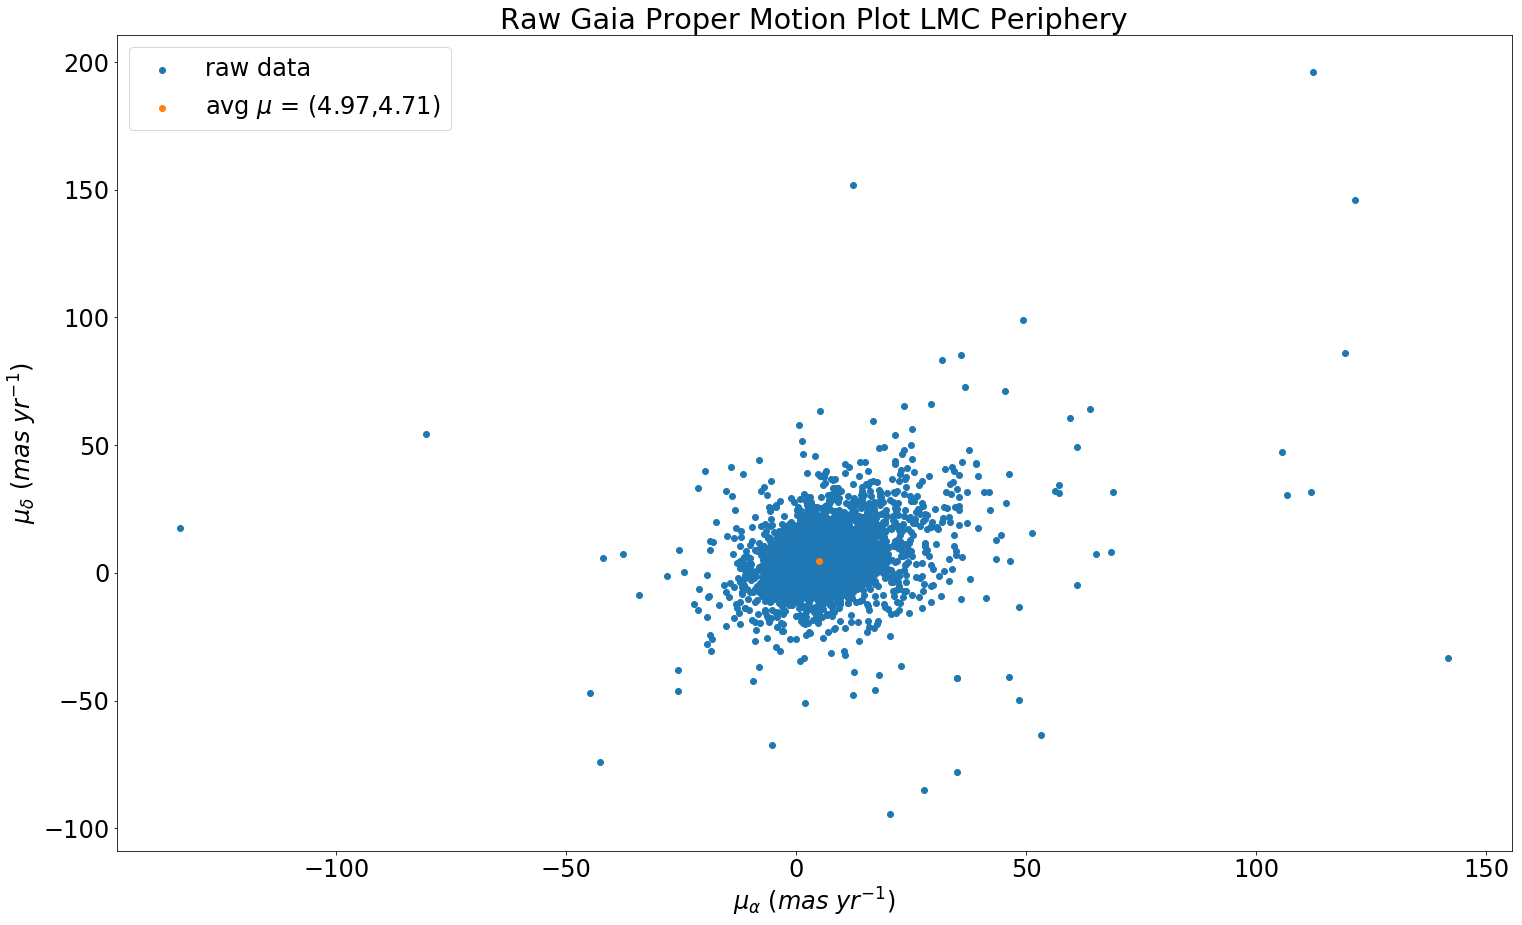

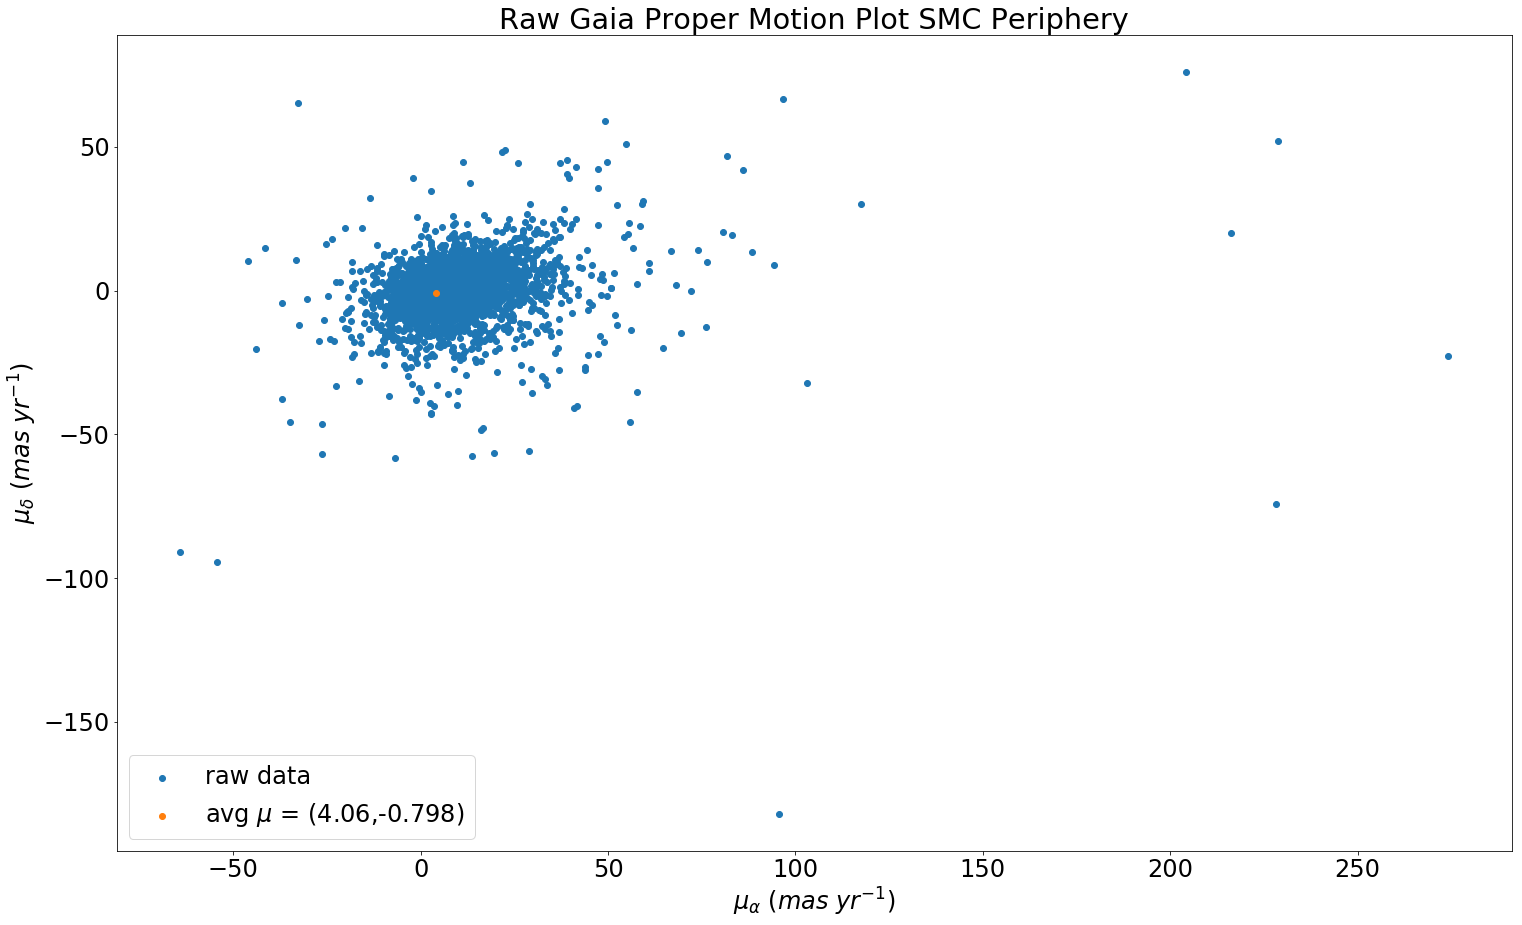

In [33]:
###Plots for proper motion in periphery 

#lpmdec, lpmra
plt.figure(figsize=[25,15])
plt.scatter(lpmra,lpmdec,label='raw data')
plt.scatter(np.nanmean(lpmra),np.nanmean(lpmdec),label='avg $\mu$ = (4.97,4.71)')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Raw Gaia Proper Motion Plot LMC Periphery')
plt.savefig('rawlmcpm.pdf',bbox_inches='tight')
plt.legend()
plt.show()

#spmdec, spmra
plt.figure(figsize=[25,15])
plt.scatter(spmra,spmdec,label='raw data')
plt.scatter(np.nanmean(spmra),np.nanmean(spmdec),label='avg $\mu$ = (4.06,-0.798)')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Raw Gaia Proper Motion Plot SMC Periphery')
plt.savefig('rawsmcpm.pdf',bbox_inches='tight')
plt.legend()
plt.show()

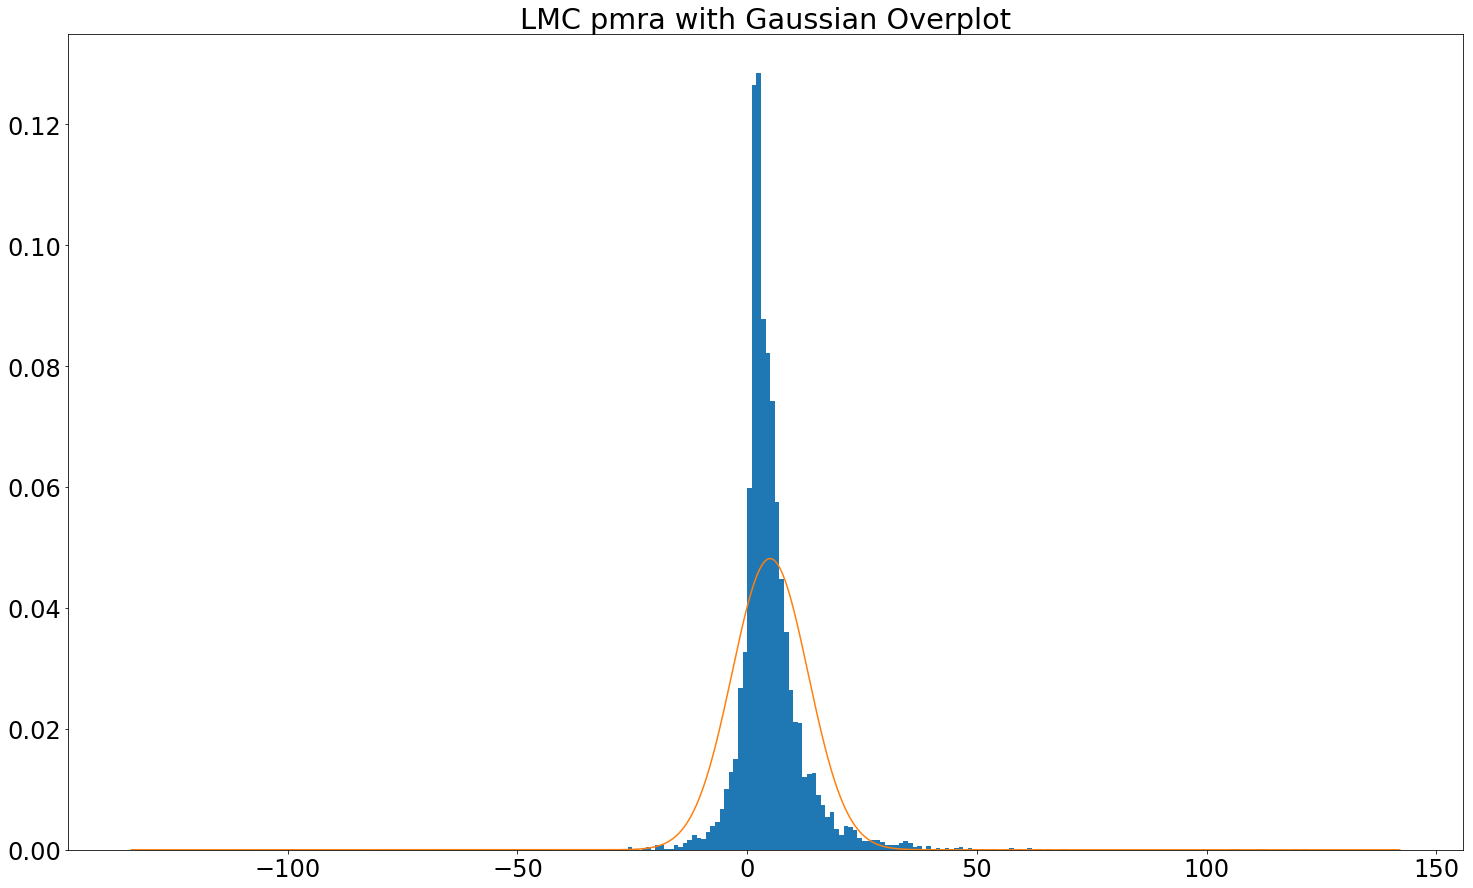

mean = 4.972736092184623
std = 8.281319872050481
skew = 2.902538903613102
kurtosis = 54.96801417759312
median = 3.5866005173141033
IQR = 5.4819872151945015


In [34]:
cleanlpmra = [x for x in lpmra if str(x) != 'nan'] #most useful code ever!!!!!!!!!!!!!!!!!!!!!

avglpmra = np.mean(cleanlpmra)
siglpmra = np.std(cleanlpmra)

zlra = np.linspace(-134,142,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanlpmra,range(-134,142),density=True)
plt.plot(zlra,gaussian(zlra,avglpmra,siglpmra))
plt.title('LMC pmra with Gaussian Overplot')
plt.savefig('rawlmcpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanlpmra)))
print('std = '+ str(np.std(cleanlpmra)))
print('skew = '+ str(skew(cleanlpmra)))
print('kurtosis = '+ str(kurtosis(cleanlpmra)))
print('median = '+ str(np.median(cleanlpmra)))
print('IQR = '+ str(iqr(cleanlpmra)))

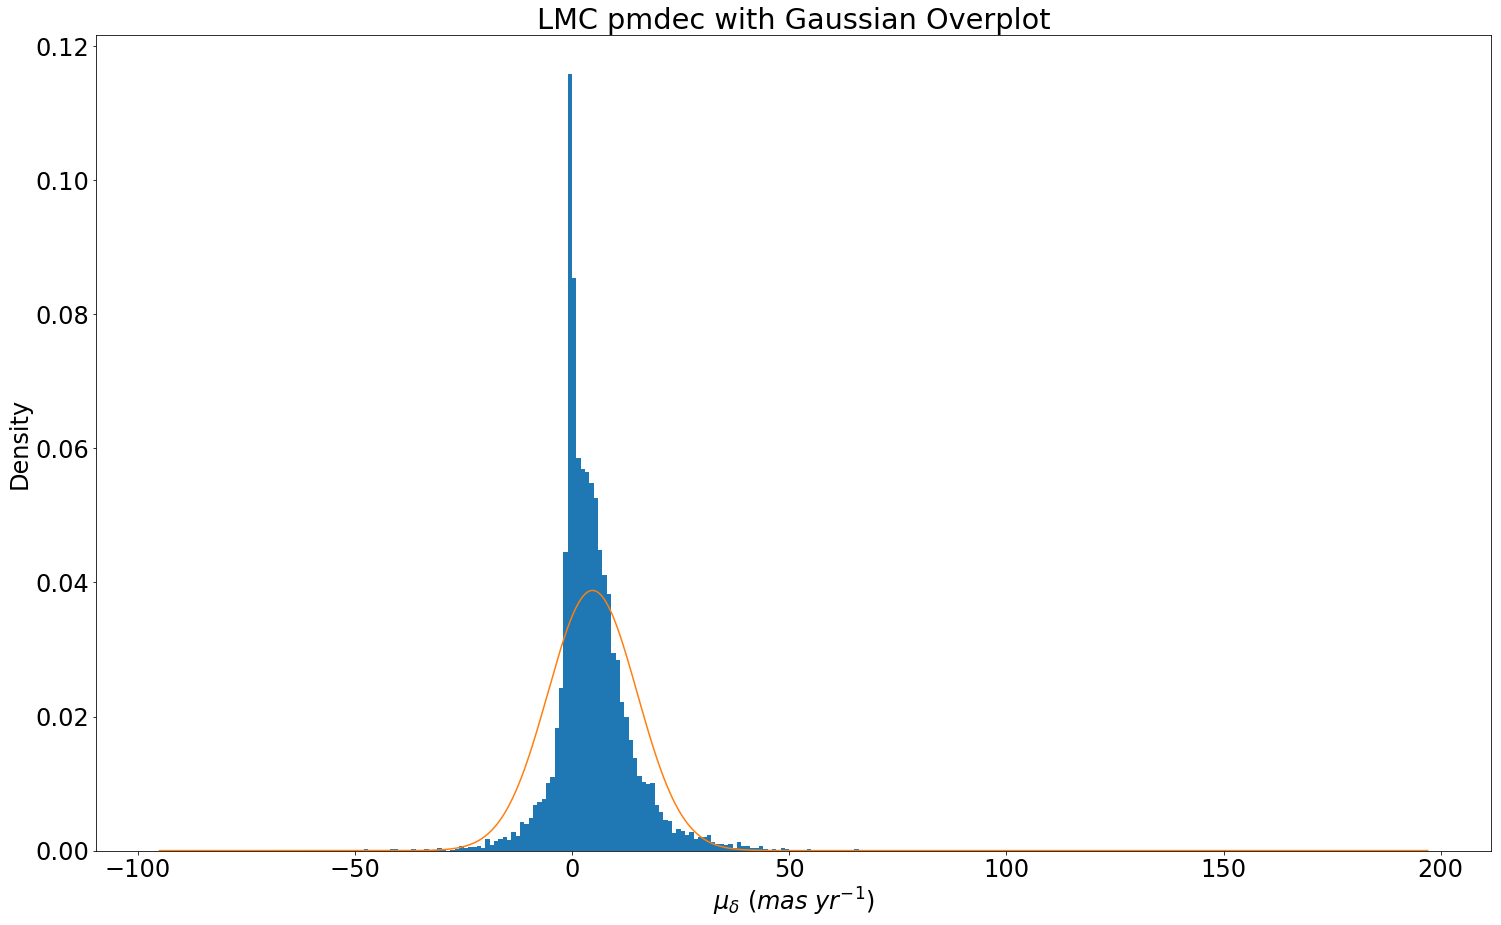

mean = 4.7076353815227305
std = 10.279501376469607
skew = 2.19653576361184
kurt = 38.36078929870392
median = 3.3299314931797124
IQR = 8.66109181397256


In [35]:
cleanlpmdec = [x for x in lpmdec if str(x) != 'nan']

avglpmdec = np.mean(cleanlpmdec)
siglpmdec = np.std(cleanlpmdec)

zldec = np.linspace(-95,197,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanlpmdec,range(-95,197),density=True)
plt.plot(zldec,gaussian(zldec,avglpmdec,siglpmdec))
plt.title('LMC pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawlmcpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanlpmdec)))
print('std = '+ str(np.std(cleanlpmdec)))
print('skew = '+ str(skew(cleanlpmdec)))
print('kurt = '+ str(kurtosis(cleanlpmdec)))
print('median = '+ str(np.median(cleanlpmdec)))
print('IQR = '+ str(iqr(cleanlpmdec)))

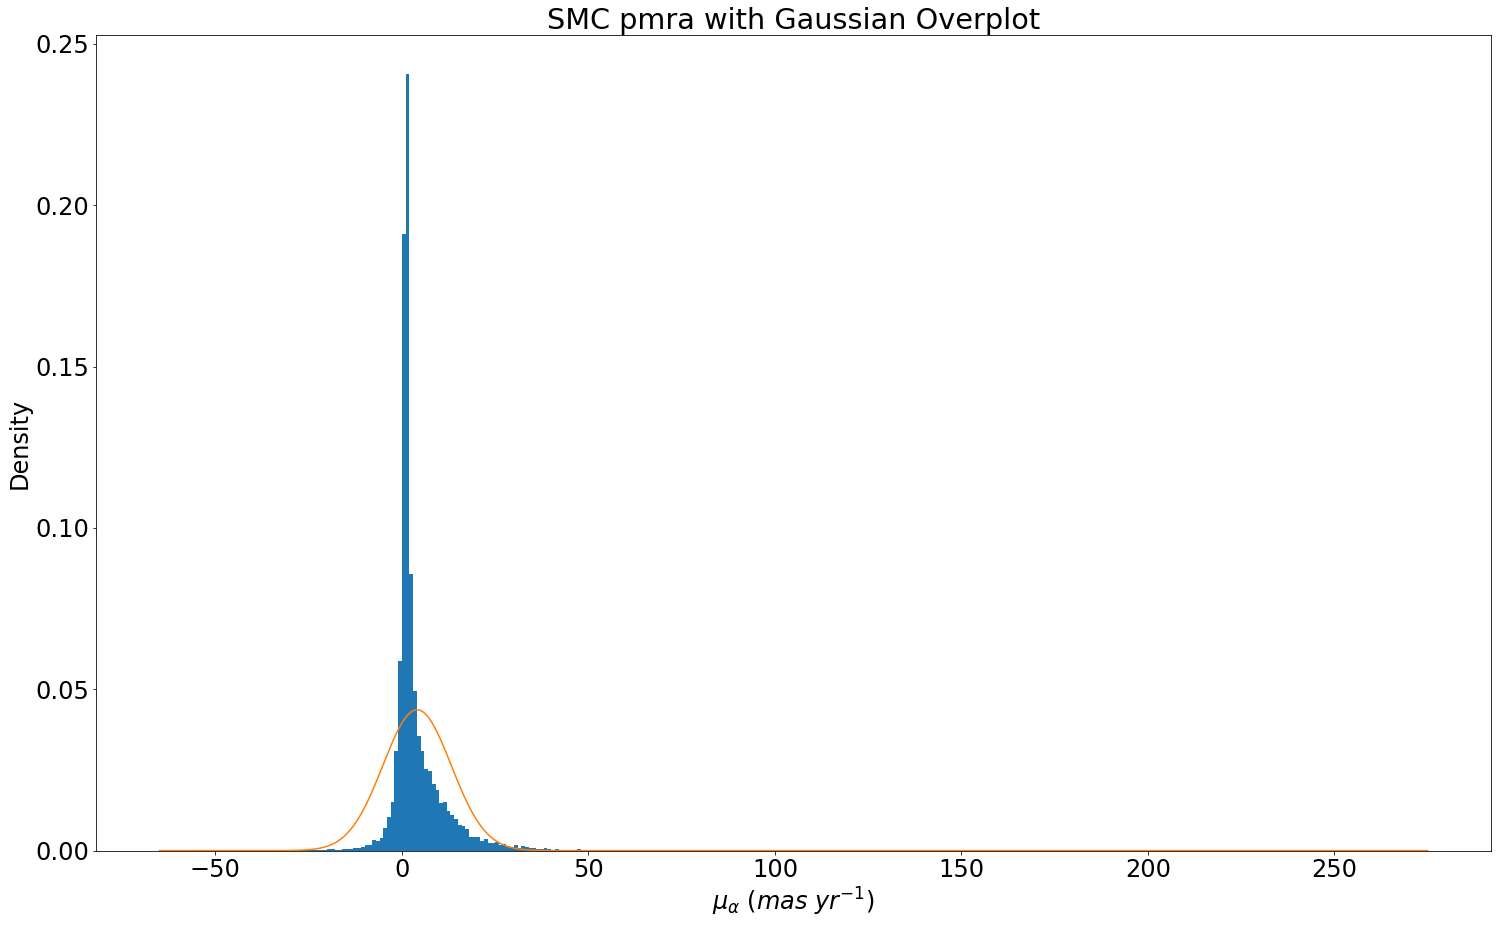

mean = 4.060394066222031
std = 9.144958887347167
skew = 8.396415923998145
kurt = 175.39368194016348
median = 1.5481506166339962
IQR = 4.404308815633078


In [36]:
cleanspmra = [x for x in spmra if str(x) != 'nan']

avgspmra = np.mean(cleanspmra)
sigspmra = np.std(cleanspmra)

zsra = np.linspace(-65,275,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanspmra,range(-65,275), density=True)
plt.plot(zsra,gaussian(zsra,avgspmra,sigspmra))
plt.title('SMC pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawsmcpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanspmra)))
print('std = '+ str(np.std(cleanspmra)))
print('skew = '+ str(skew(cleanspmra)))
print('kurt = '+ str(kurtosis(cleanspmra)))
print('median = '+ str(np.median(cleanspmra)))
print('IQR = '+ str(iqr(cleanspmra)))

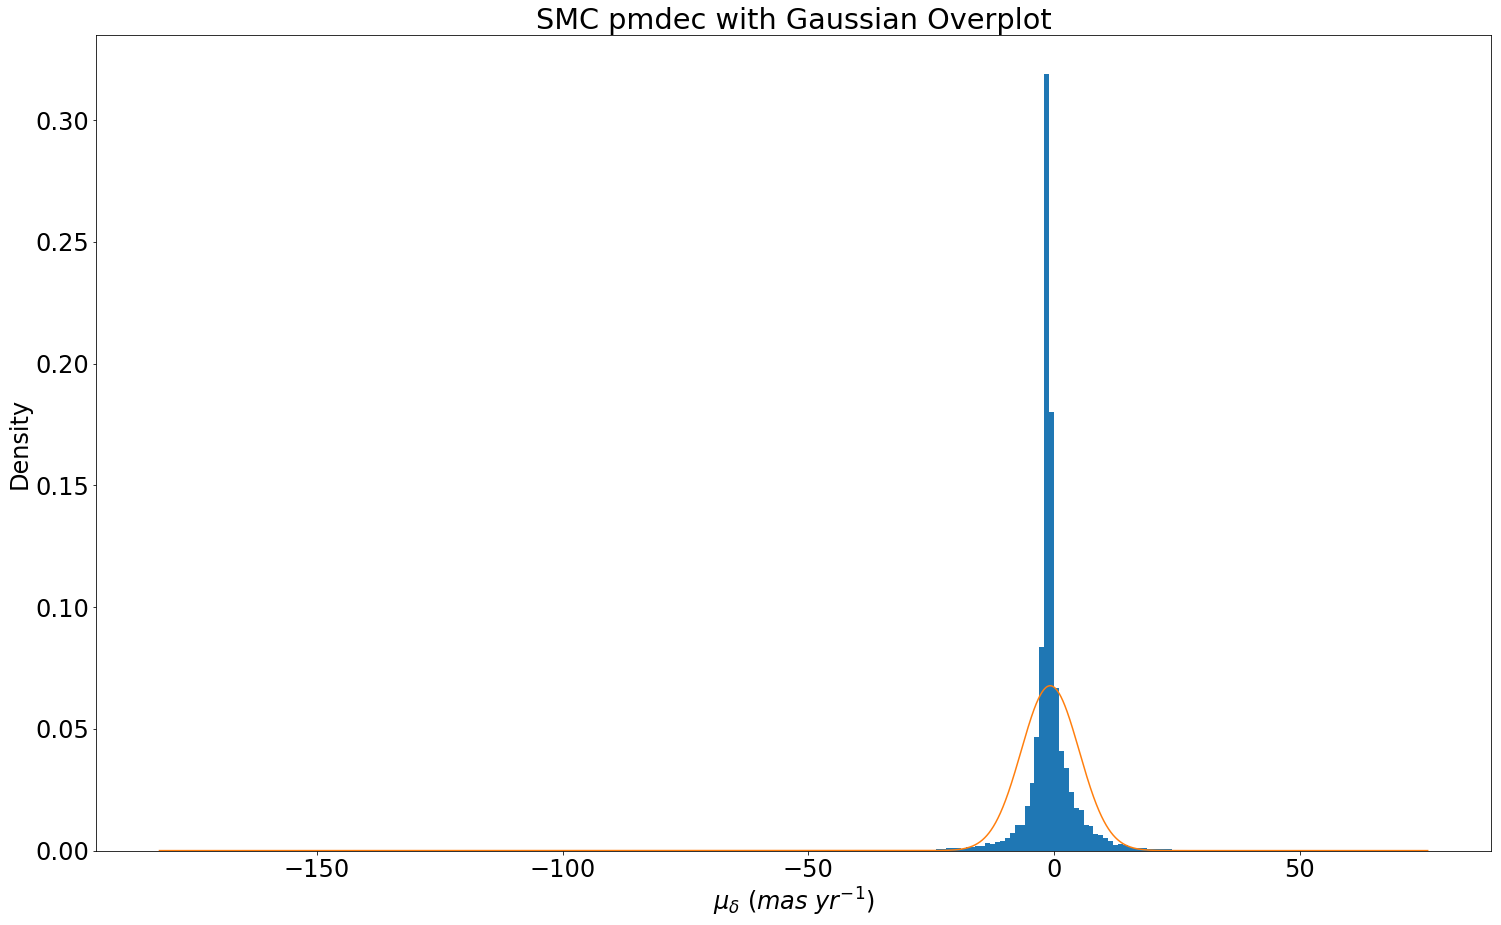

mean = -0.7977984950028141
std = 5.89254053748466
skew = -2.756973261025786
kurt = 103.86610561995501
median = -1.1504470092479984
IQR = 2.0730054140371257


In [37]:
cleanspmdec = [x for x in spmdec if str(x) != 'nan']

avgspmdec = np.mean(cleanspmdec)
sigspmdec = np.std(cleanspmdec)

zsdec = np.linspace(-182,76,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanspmdec,range(-182,76), density=True)
plt.plot(zsdec,gaussian(zsdec,avgspmdec,sigspmdec))
plt.title('SMC pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Density')
plt.savefig('rawsmcpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanspmdec)))
print('std = '+ str(np.std(cleanspmdec)))
print('skew = '+ str(skew(cleanspmdec)))
print('kurt = '+ str(kurtosis(cleanspmdec)))
print('median = '+ str(np.median(cleanspmdec)))
print('IQR = '+ str(iqr(cleanspmdec)))

In [38]:
###REad in Simulated Milky Way Data
bes = astropy.io.ascii.read('/Users/joshpovick/Desktop/Research/MS_young/besancon.dat')
mpmra = bes['mux']*10.0
mpmdec = bes['muy']*10.0
tbes = Table(bes)
tbes.show_in_browser(jsviewer=True)

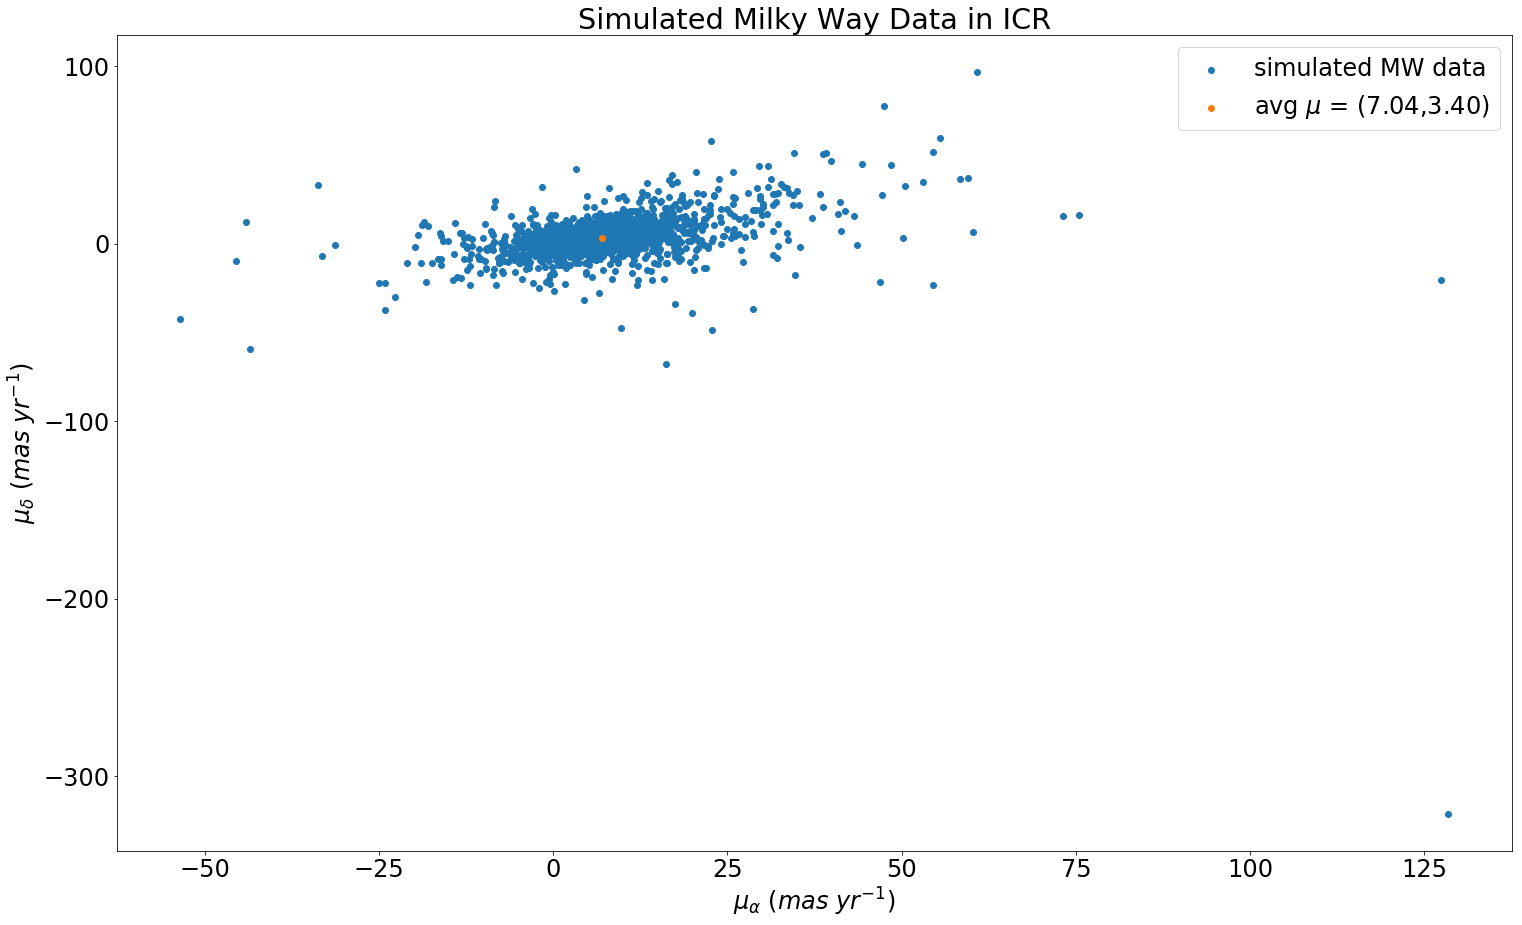

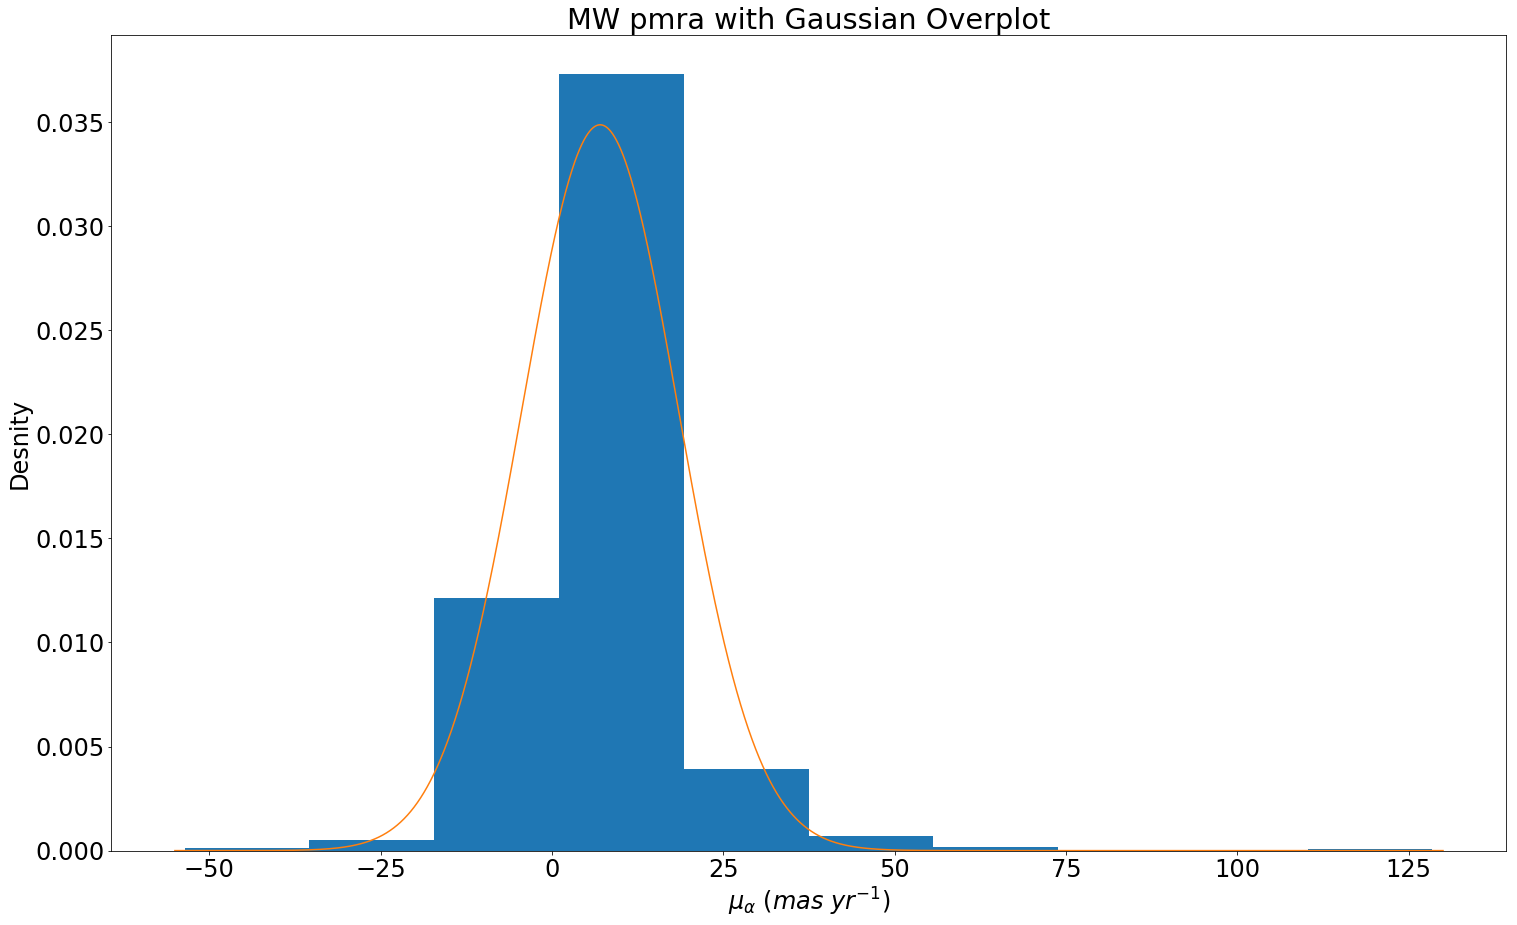

mean = 7.041079219288174
std = 11.439384878122633
skew = 2.0736814983651577
kurt = 18.33896458093757
median = 5.734999999999999
IQR = 9.73


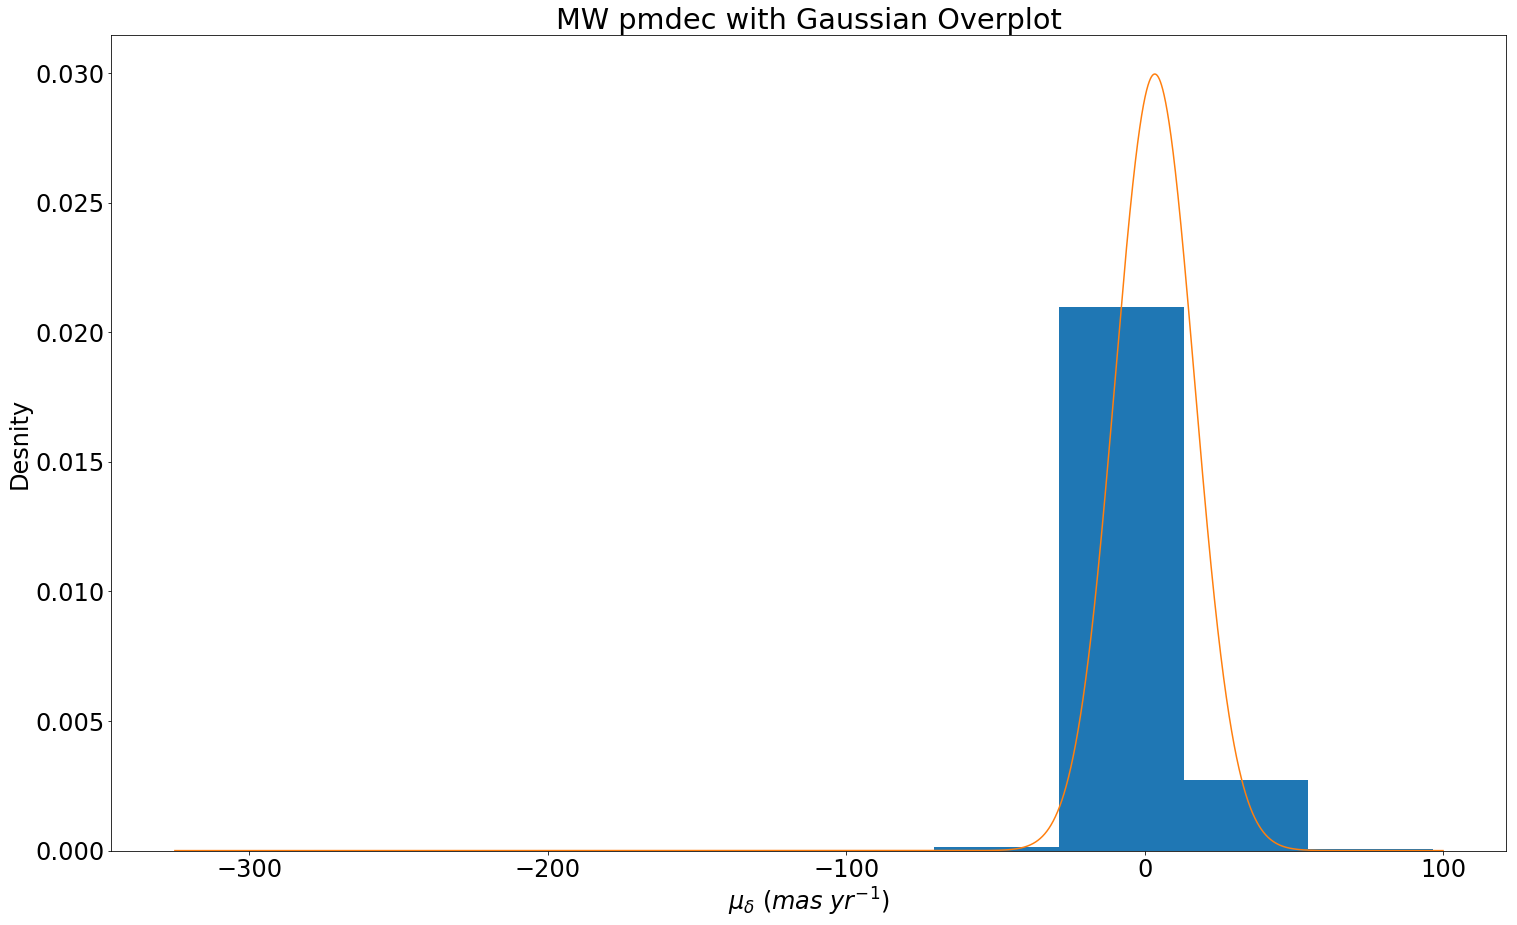

mean = 3.3980367393800224
std = 13.312777497970727
skew = -7.904045585307047
kurt = 205.04349721472977
median = 2.965
IQR = 9.215000000000002


In [39]:
###Milky Way Simulated Data Plots

#mpmdec, mpmra
plt.figure(figsize=[25,15])
plt.scatter(mpmra,mpmdec,label='simulated MW data')
plt.scatter(np.nanmean(mpmra),np.nanmean(mpmdec),label='avg $\mu$ = (7.04,3.40)')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.title('Simulated Milky Way Data in ICR')
plt.savefig('simmwpm.pdf',bbox_inches='tight')
plt.legend()
plt.savefig('simmwpm.pdf',bbox_inches='tight')
plt.show()

#MW pmra + Statistics
cleanmpmra = [x for x in mpmra if str(x) != 'nan']

avgmpmra = np.mean(cleanmpmra)
sigmpmra = np.std(cleanmpmra)

zmra = np.linspace(-55,130,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

plt.figure(figsize=[25,15])
plt.hist(cleanmpmra, density=True)
plt.plot(zmra,gaussian(zmra,avgmpmra,sigmpmra))
plt.title('MW pmra with Gaussian Overplot')
plt.xlabel('$\mu_{\\alpha}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('simmwpmra.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanmpmra)))
print('std = '+ str(np.std(cleanmpmra)))
print('skew = '+ str(skew(cleanmpmra)))
print('kurt = '+ str(kurtosis(cleanmpmra)))
print('median = '+ str(np.median(cleanmpmra)))
print('IQR = '+ str(iqr(cleanmpmra)))

#MW pmdec + Statistics
cleanmpmdec = [x for x in mpmdec if str(x) != 'nan']

avgmpmdec = np.mean(cleanmpmdec)
sigmpmdec = np.std(cleanmpmdec)

zmdec = np.linspace(-325,100,10000)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

fig = plt.figure(figsize=[25,15])
plt.hist(cleanmpmdec, density=True)
plt.plot(zmdec,gaussian(zmdec,avgmpmdec,sigmpmdec))
plt.title('MW pmdec with Gaussian Overplot')
plt.xlabel('$\mu_{\delta}$ $(mas$ $yr^{-1}$)')
plt.ylabel('Desnity')
plt.savefig('simmwpmdec.pdf',bbox_inches='tight')
plt.show()

print('mean = '+ str(np.mean(cleanmpmdec)))
print('std = '+ str(np.std(cleanmpmdec)))
print('skew = '+ str(skew(cleanmpmdec)))
print('kurt = '+ str(kurtosis(cleanmpmdec)))
print('median = '+ str(np.median(cleanmpmdec)))
print('IQR = '+ str(iqr(cleanmpmdec)))

In [23]:
###Create a Table of All Statistics

name = np.array(['LMC pmra', 'LMC pmdec', 'SMC pmra', 'SMC pmdec', 'MW pmra', 'MW pmdec'])
mean = np.array([np.mean(cleanlpmra),np.mean(cleanlpmdec),np.mean(cleanspmra),np.mean(cleanspmdec),np.mean(cleanmpmra),np.mean(cleanmpmdec)])
STD = np.array([np.std(cleanlpmra),np.std(cleanlpmdec),np.std(cleanspmra),np.std(cleanspmdec),np.std(cleanmpmra),np.std(cleanmpmdec)])
median = np.array([np.median(cleanlpmra),np.median(cleanlpmdec),np.median(cleanspmra),np.median(cleanspmdec),np.median(cleanmpmra),np.median(cleanmpmdec)])
IQR = np.array([iqr(cleanlpmra),iqr(cleanlpmdec),iqr(cleanspmra),iqr(cleanspmdec),iqr(cleanmpmra),iqr(cleanmpmdec)])
ske = np.array([float(skew(cleanlpmra)),float(skew(cleanlpmdec)),float(skew(cleanspmra)),float(skew(cleanspmdec)),float(skew(cleanmpmra)),float(skew(cleanmpmdec))])
kurt = np.array([float(kurtosis(cleanlpmra)),float(kurtosis(cleanlpmdec)),float(kurtosis(cleanspmra)),float(kurtosis(cleanspmdec)),float(kurtosis(cleanmpmra)),float(kurtosis(cleanmpmdec))])
data = Table([name, mean, STD, median, IQR, ske, kurt], names=['name', 'mean', 'std', 'median', 'IQR', 'skew', 'kurtosis'])
ascii.write(data, 'stats.dat')


In [24]:
data.show_in_browser(jsviewer=True)

In [25]:
ascii.read('stats.dat')

name,mean,std,median,IQR,skew,kurtosis
str9,float64,float64,float64,float64,float64,float64
LMC pmra,4.972736092184623,8.281319872050481,3.5866005173141033,5.4819872151945015,2.902538903613102,54.96801417759312
LMC pmdec,4.7076353815227305,10.279501376469607,3.3299314931797124,8.66109181397256,2.19653576361184,38.36078929870392
SMC pmra,4.060394066222031,9.144958887347167,1.5481506166339962,4.404308815633078,8.396415923998145,175.39368194016348
SMC pmdec,-0.7977984950028141,5.89254053748466,-1.1504470092479984,2.0730054140371257,-2.756973261025786,103.86610561995501
MW pmra,7.041079219288174,11.439384878122633,5.734999999999999,9.73,2.0736814983651577,18.33896458093757
MW pmdec,3.3980367393800224,13.312777497970727,2.965,9.215000000000002,-7.904045585307047,205.04349721472977
